In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
pd.set_option('display.max_rows', 5)

## Read log files

In [18]:
host_logs = pd.read_parquet("data/host_logs.parquet")

In [19]:
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
0,2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
1,2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6475641,2020-10-07 16:10:08,60,747.976562,4,4.0,18.734375,nesh-fe1-adm,nan,2.585938,1.410156,4.0
6475642,2020-10-07 16:10:08,60,746.683594,4,4.3,20.027344,nesh-fe2-adm,nan,0.000000,3.996094,4.8


## Set index

In [7]:
host_logs = host_logs.set_index("Date")

## Login nodes

**FIXME:** The following now un-necessarily and wronly swaps free and used mem.

In [8]:
def plot_for_these_login_nodes(login_nodes, variable, ylabel):
    print('\n'+ylabel)
    for login_node in login_nodes:
        this_node = host_logs["ExecutionHost"].str.contains('nesh-'+login_node+'-adm')
        time_series = host_logs[this_node][variable].resample('6h').mean()
        time_series.plot(label=login_node)
        plt.legend(); plt.grid(); plt.ylabel(ylabel)
        quantile = time_series.quantile([0.05, 0.50, 0.95])
        print("{}:  {:4.2f} {:4.2f} {:4.2f}".format(
            login_node, quantile[0.05], quantile[0.50], quantile[0.95])
             )

def plot_for_login_nodes(variable, ylabel):
    plot_for_these_login_nodes(['fe1', 'fe2', 'fe3'], variable, ylabel)


Memory utilization in GB
fe1:  14.38 25.15 191.17
fe2:  14.23 26.38 296.63
fe3:  14.34 29.35 259.77


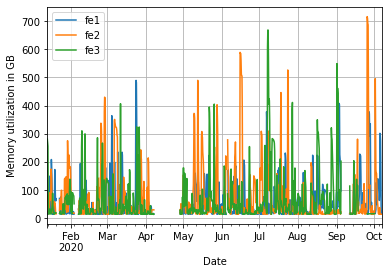

In [9]:
plt.figure(); plot_for_login_nodes("Used_Mem1", 'Memory utilization in GB')


Occupied CPUs
fe1:  1.00 4.22 11.26
fe2:  0.14 2.44 15.79
fe3:  0.61 4.19 13.56

CPU utilization
fe1:  0.28 3.71 10.62
fe2:  0.04 1.96 15.19
fe3:  0.12 3.81 12.87

Load average
fe1:  0.27 5.06 21.76
fe2:  0.08 3.43 17.33
fe3:  0.19 6.96 24.66


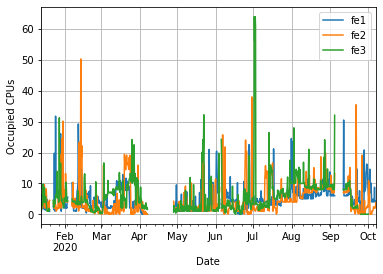

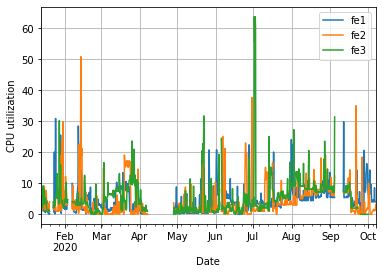

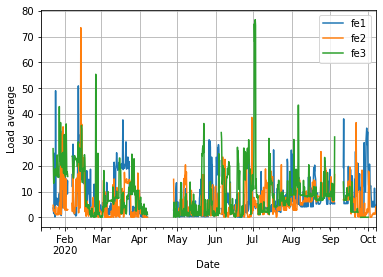

In [10]:
plt.figure(); plot_for_login_nodes("Used_CPUs", "Occupied CPUs")
plt.figure(); plot_for_login_nodes("Cpu", "CPU utilization")
plt.figure(); plot_for_login_nodes("Load", "Load average")

## Login and feque batch node
This is a hybrid node that can be accessed both via SSH and with batch job tasks.


Memory utilization in GB
fe0:  15.32 43.00 610.40


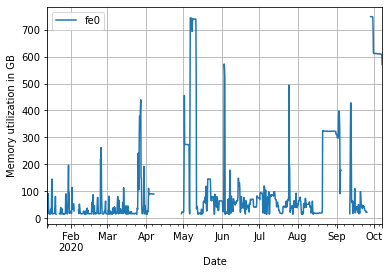

In [11]:
plt.figure(); plot_for_these_login_nodes(['fe0'], "Used_Mem1",
                                         'Memory utilization in GB')


Occupied CPUs
fe0:  0.03 1.00 2.94

CPU utilization
fe0:  0.01 0.35 2.64

Load average
fe0:  0.06 1.24 11.88


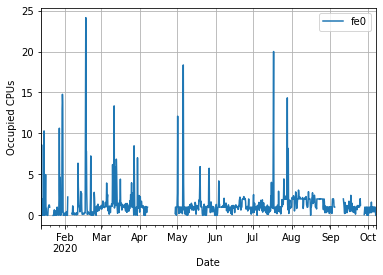

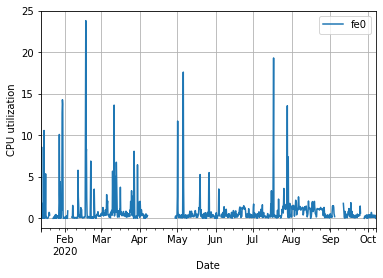

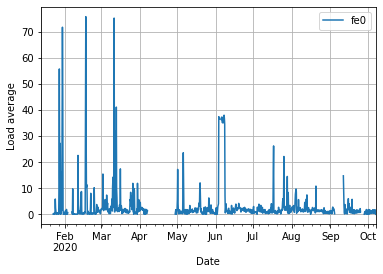

In [12]:
plt.figure(); plot_for_these_login_nodes(["fe0"], "Used_CPUs", "Occupied CPUs")
plt.figure(); plot_for_these_login_nodes(["fe0"], "Cpu", "CPU utilization")
plt.figure(); plot_for_these_login_nodes(["fe0"], "Load", "Load average")

## Batch production nodes
Nodes in the `clexpress`, `clmedium` and `cllong` batch classes have the same hardware configuration, i.e. the same type of CPUs and memory sizes. Nodes in the `clbigmem` batch class have larger memory size, and compute nodes in the `clfo2` batch class have other CPU types and memory sizes.

In [13]:
def plot_for_batch_nodes(these_nodes, this_queue):
    
    tbox = dict(facecolor='white', alpha=0.75, edgecolor='white')

    # Calculate meta information. (Without consistency checks.)
    
    total_host_number = these_nodes['ExecutionHost'].unique().size
    base_cpu_number = (these_nodes['Free_CPUs'].astype('int') +
                       these_nodes['Used_CPUs'].astype('int')).mean()
    base_memory_size = (these_nodes['Free_Mem1'].astype('int') +
                        these_nodes['Used_Mem1'].astype('int')).mean()
    
    # Define conversions for secondary axis object.
    # https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
    
    def abs2rel_cpu(abs_number):
        return (100*abs_number/base_cpu_number)/total_host_number
    def rel2abs_cpu(rel_number):
        return (rel_number/100*base_cpu_number)*total_host_number
    def abs2rel_mem(abs_number):
        return (100*abs_number/base_memory_size)/total_host_number
    def rel2abs_mem(rel_number):
        return (rel_number/100*base_memory_size)*total_host_number

    # Plot CPU stuff.
    
    plt.figure()
    time_series = 100*these_nodes['Used_CPUs'].resample('1h').mean()/base_cpu_number
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}% or {:4.0f} CPUs'.format(time_series.median(), rel2abs_cpu(time_series.median())), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('occupied CPUs in %\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_cpu, abs2rel_cpu))
    secaxy.set_ylabel('total number of occupied CPUs\nfor '+this_queue+' batch class')
    plt.grid()
    
    # Plot more CPU stuff.
    
    plt.figure()
    time_series = 100*these_nodes['Cpu'].resample('1h').mean()/base_cpu_number
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}% or {:4.0f} CPUs'.format(time_series.median(), rel2abs_cpu(time_series.median())), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('utilized CPUs in %\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_cpu, abs2rel_cpu))
    secaxy.set_ylabel('total number of utilized CPUs\nfor '+this_queue+' batch class')
    plt.grid()
    
    # Plot load average stuff.
    
    plt.figure()
    time_series = these_nodes['Load'].resample('1h').mean()/base_cpu_number
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}'.format(time_series.median()), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('normalized load average\n'+str(total_host_number)+' execution host average')
    plt.title(this_queue+': '+str(base_cpu_number)+' CPUs per execution host')
    plt.grid()
    
    # Plot memory stuff.
    
    plt.figure()
    time_series = 100*these_nodes['Used_Mem1'].resample('3h').mean()/base_memory_size
    ax = time_series.plot()
    plt.hlines(time_series.median(), these_nodes.index[0], these_nodes.index[-1], 'm')
    t = plt.text(0.1,0.1,'median: {:3.1f}% or {:4.1f} GB'.format(time_series.median(),rel2abs_mem(time_series.median())), transform=ax.transAxes, color='m')
    t.set_bbox(tbox)
    plt.ylabel('utilized memory in %\n'+str(total_host_number)+' execution host average')
    plt.title('{}: {:4.1f} GB per execution host '.format(this_queue, base_memory_size))
    secaxy = ax.secondary_yaxis('right',functions=(rel2abs_mem,abs2rel_mem))
    secaxy.set_ylabel('total utilized memory in GB\nfor '+this_queue+' batch class')
    plt.grid()
    

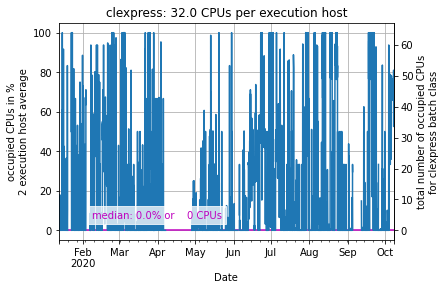

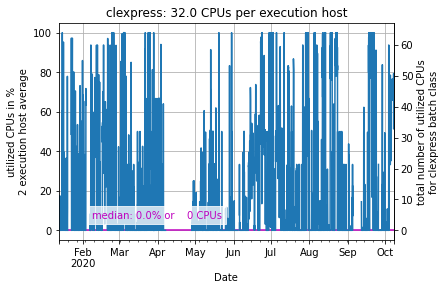

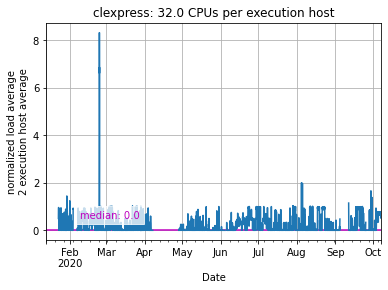

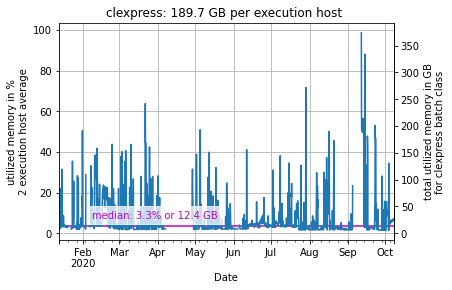

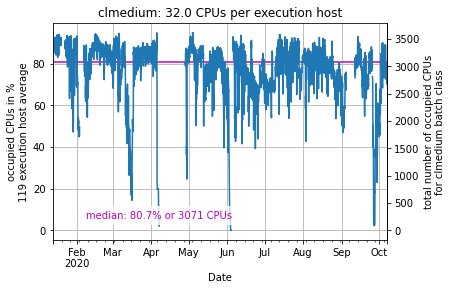

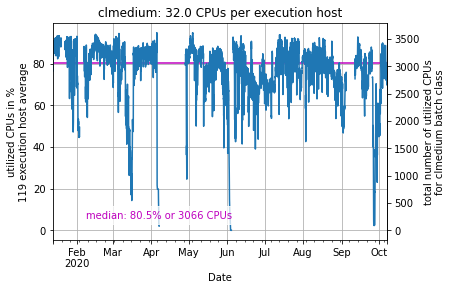

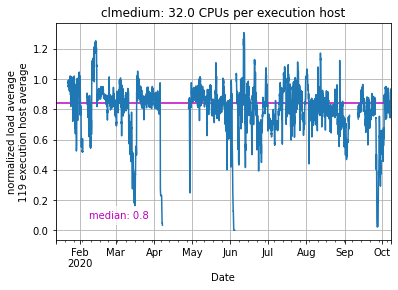

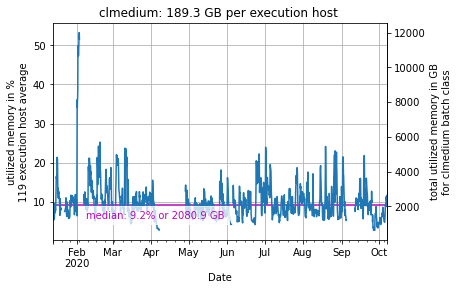

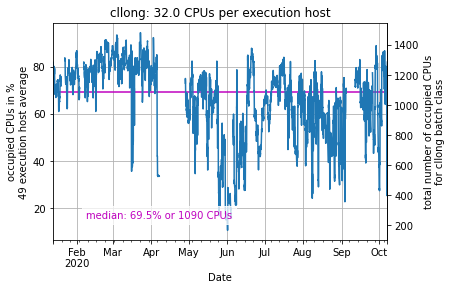

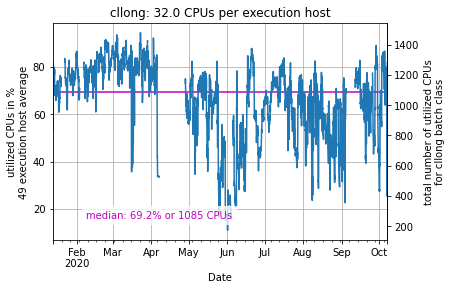

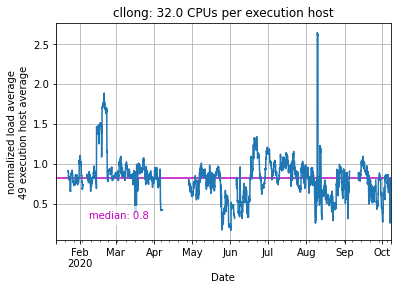

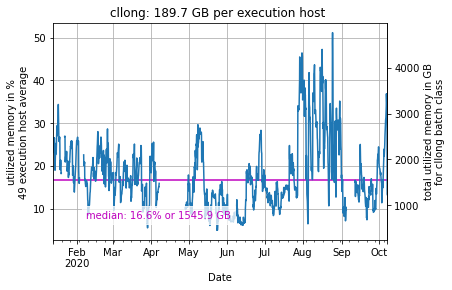

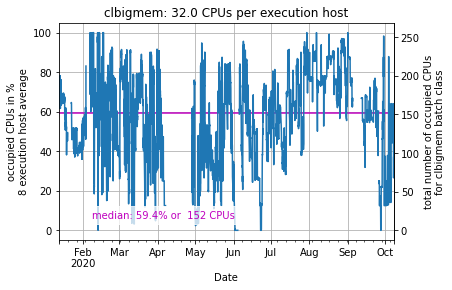

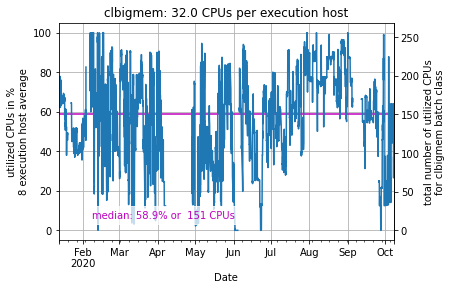

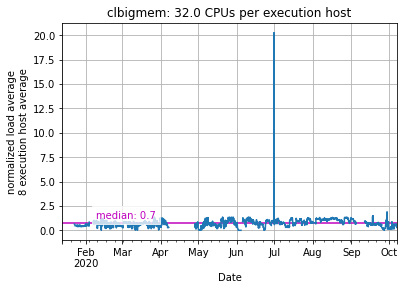

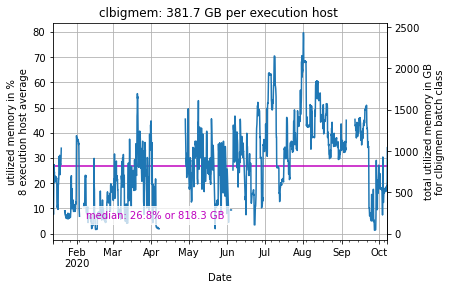

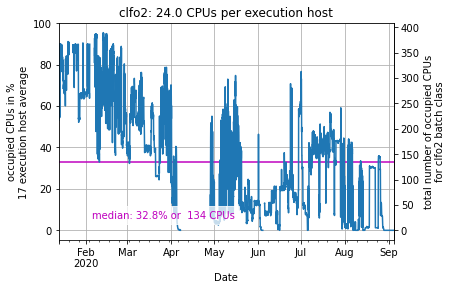

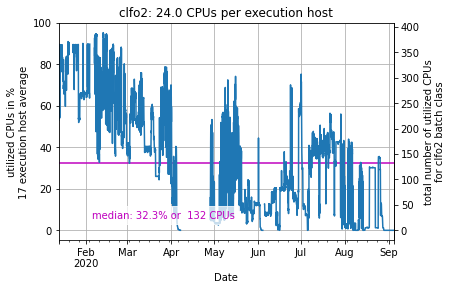

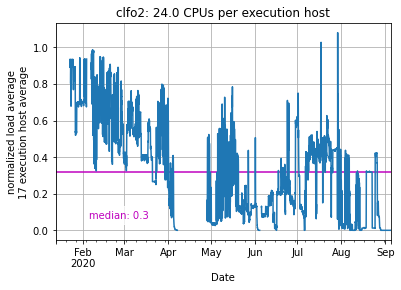

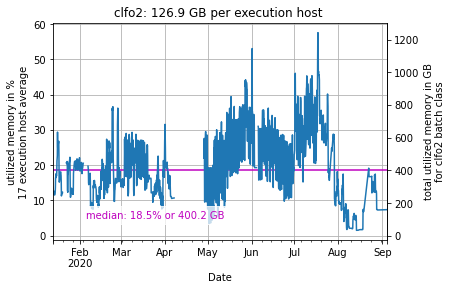

In [14]:
for this_batch_class in ['clexpress', 'clmedium', 'cllong', 'clbigmem', 'clfo2']:
    these_nodes = host_logs["QueueName"].str.contains(this_batch_class)
    plot_for_batch_nodes(host_logs[these_nodes], this_batch_class)

Now, estimate utilization for identical CPU type execution hosts.

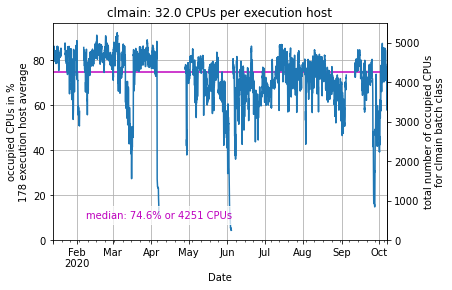

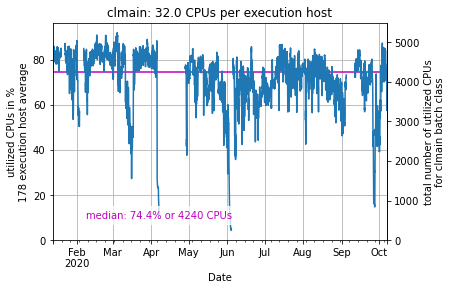

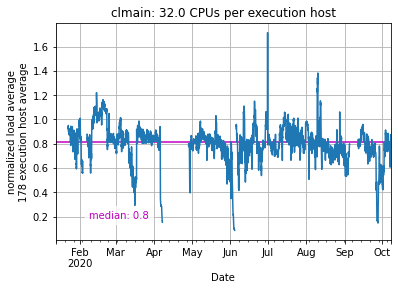

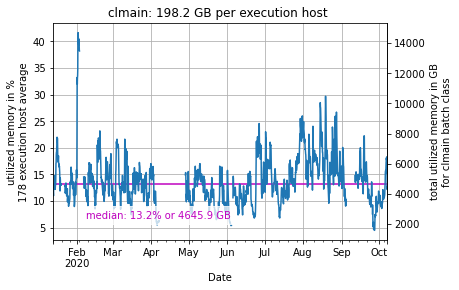

In [15]:
these_batch_classes = 'clexpress|clmedium|cllong|clbigmem'
these_nodes = host_logs["QueueName"].str.contains(these_batch_classes)
plot_for_batch_nodes(host_logs[these_nodes], 'clmain')

## Add example histograms...

<AxesSubplot:>

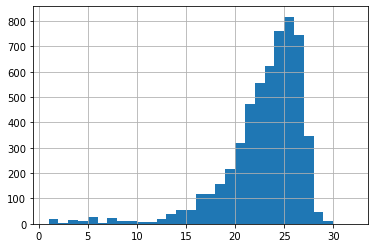

In [16]:
these_batch_classes = 'clexpress|clmedium|cllong|clbigmem'
these_nodes = host_logs["QueueName"].str.contains(these_batch_classes)
host_logs[these_nodes]["Used_CPUs"].resample('1h').mean().hist(bins=np.arange(1,33,1))

<AxesSubplot:>

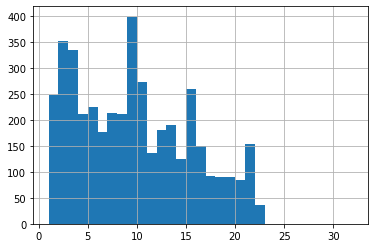

In [17]:
these_nodes = host_logs["QueueName"].str.contains('clfo2')
host_logs[these_nodes]["Used_CPUs"].resample('1h').mean().hist(bins=np.arange(1,33,1))

## Separation in weekdays and hours

In [9]:
host_logs

,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
Date,,,,,,,,,,
2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-10-07 16:10:08,60,747.976562,4,4.0,18.734375,nesh-fe1-adm,nan,2.585938,1.410156,4.0
2020-10-07 16:10:08,60,746.683594,4,4.3,20.027344,nesh-fe2-adm,nan,0.000000,3.996094,4.8


In [10]:
#Masks to separate queue type: 'clexpress', 'clmedium', 'cllong', 'clbigmem', 'clfo2'
batch_classes = ['clexpress', 'clmedium', 'cllong', 'clbigmem', 'clfo2']

In [11]:
def daily_cycle_mean(df, queue_name, column):
    queues = df.loc[df['QueueName'].str.contains(queue_name)]
    hourly = queues.groupby(queues['Date'].dt.hour)[column].mean()
    return(hourly)

def weekly_cycle_mean(df, queue_name, column):
    week   = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    queues = df.loc[df['QueueName'].str.contains(queue_name)]
    weekly = queues.groupby(queues['Date'].dt.day_name())[column].mean().reindex(week)
    return(weekly)

In [12]:
def histogram_dataframe(df, batch_classes, CPUs=False, weekly = False):
    new_df = {}
    axis   = 'Hour'
    for batch_class in batch_classes:
        if CPUs:
            if weekly:
                used = weekly_cycle_mean(df, batch_class, 'Used_CPUs')
                free = weekly_cycle_mean(df, batch_class, 'Free_CPUs')
                axis = 'Day'
            else:
                used = daily_cycle_mean(df, batch_class, 'Used_CPUs')
                free = daily_cycle_mean(df, batch_class, 'Free_CPUs')
        else:
            if weekly:
                used = weekly_cycle_mean(df, batch_class, 'Used_Mem1')
                free = weekly_cycle_mean(df, batch_class, 'Free_Mem1')
                axis = 'Day'
            else:
                used = daily_cycle_mean(df, batch_class, 'Used_Mem1')
                free = daily_cycle_mean(df, batch_class, 'Free_Mem1')
            
        new_df[batch_class] = 100*used/(used+free)
    new_df = pd.DataFrame(new_df).rename_axis(axis)
    return(new_df)

In [13]:
mem_day  = histogram_dataframe(host_logs,batch_classes)
mem_week = histogram_dataframe(host_logs,batch_classes, weekly = True)
cpu_day  = histogram_dataframe(host_logs,batch_classes, CPUs = True)
cpu_week = histogram_dataframe(host_logs,batch_classes, weekly = True, CPUs = True)

KeyError: 'Date'

In [ ]:
mem_week.plot.bar(figsize = (20,10))
plt.ylabel('Used Memory in %')
plt.title('Weekly cycle of memory usage')
mem_day.plot.bar(figsize = (20,10), width = 0.8)
plt.ylabel('Used Memory in %')
plt.title('Daily cycle of memory usage')
cpu_week.plot.bar(figsize = (20,10))
plt.ylabel('Used CPUs in %')
plt.title('Weekly cycle of used CPUs')
cpu_day.plot.bar(figsize = (20,10), width = 0.8)
plt.ylabel('Used CPUs in %')
plt.title('Daily cycle of used CPUs')

In [14]:
def quantiles(df,batch_classes,quantiles):
    quants = {}
    for batch_class in batch_classes:
        host_fraction       = df.loc[df['QueueName'].str.contains(batch_class)]
        quants[batch_class] = (100*host_fraction['Used_Mem1']/(host_fraction['Used_Mem1']+host_fraction['Free_Mem1'])).quantile(quantiles)
    quantiles_df = pd.DataFrame(quants)
    return(quantiles_df)

## New dataframe with fractions instead of absolute numbers

In [15]:
def Resource_Fraction(df, res='Mem1'):
    df_new                = df.set_index('Date')
    df_new['Fraction']    = 100* df_new['Used_'+res] / (df_new['Free_'+res]+df_new['Used_'+res])
    df_new                = df_new.reset_index()
    df_new['Weekday']     = df.reset_index()['Date'].dt.day_name()
    df_new['Hour']        = df.reset_index()['Date'].dt.hour
    weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    #Assign the above list to category ranking
    wDays = pd.api.types.CategoricalDtype(ordered= True, categories=weekday)
    #Apply this to the specific column in DataFrame
    df_new['Weekday'] = df_new['Weekday'].astype(wDays)
    return(df_new[['Fraction','QueueName','Weekday','Hour']])

In [16]:
def Box_plot(df,batch_class, week=False, whiskers=(10,90),wcolor='black',bcolor='black',mcolor='darkred',titlestr='Fraction of used memory in %'):
    wprops  = dict(color=wcolor)
    bprops  = dict(color=bcolor)
    mprops  = dict(color=mcolor)
    if week:
        ax  = df.loc[df['QueueName'].str.contains(batch_class)].boxplot(
            column='Fraction',by='Weekday',whis=whiskers,showfliers=False,
            boxprops=bprops,whiskerprops=wprops,medianprops=mprops,figsize=(20,10)
        )
    else:
        ax  = df.loc[df['QueueName'].str.contains(batch_class)].boxplot(
            column='Fraction',by='Hour',whis=whiskers,showfliers=False,
            boxprops=bprops,whiskerprops=wprops,medianprops=mprops,figsize=(20,10)
        )
    plt.ylabel(titlestr)
    ax.set_title(batch_class)
    plt.show()
    

## Daily cycles of used memory for all batch classes:

In [20]:
host_logs_mem = Resource_Fraction(host_logs)

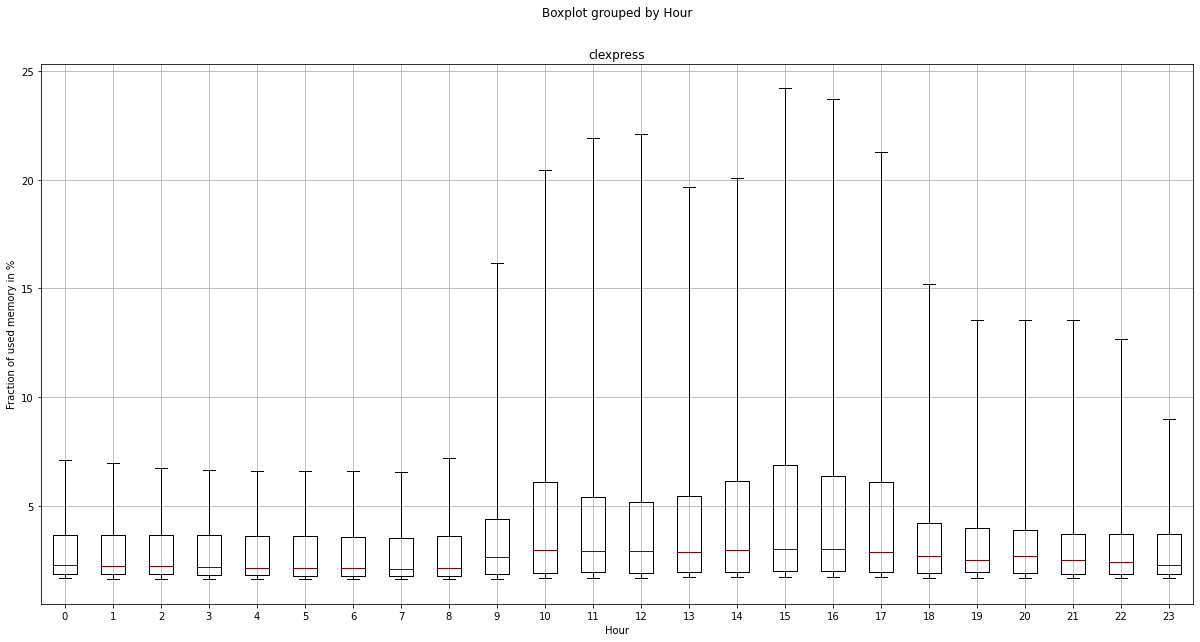

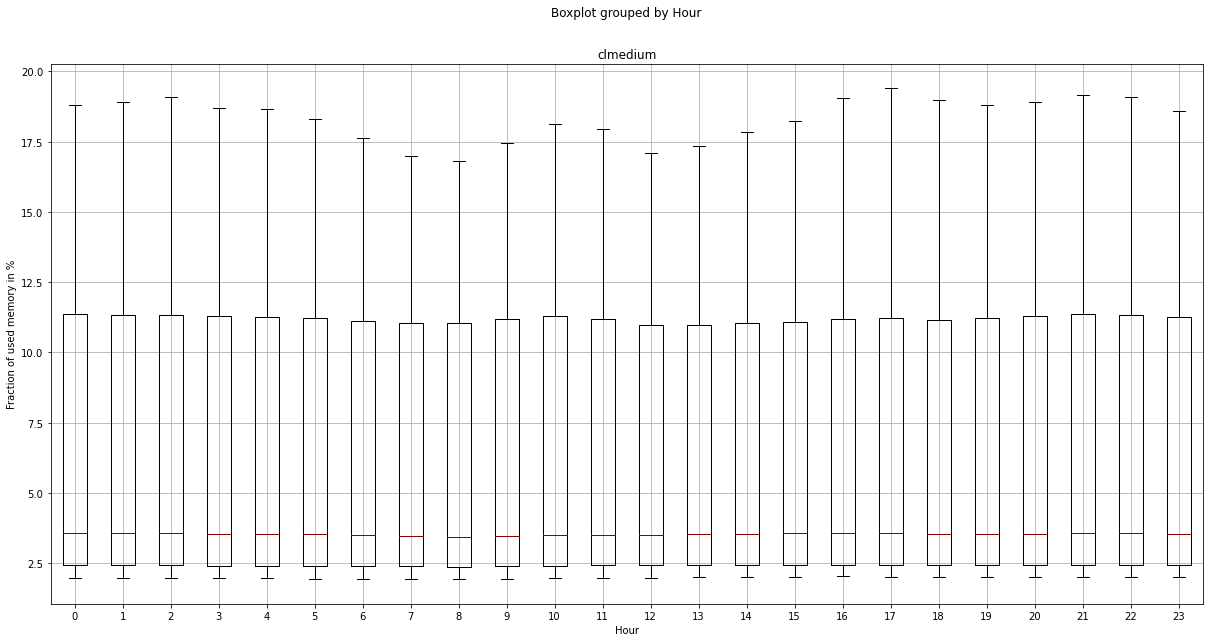

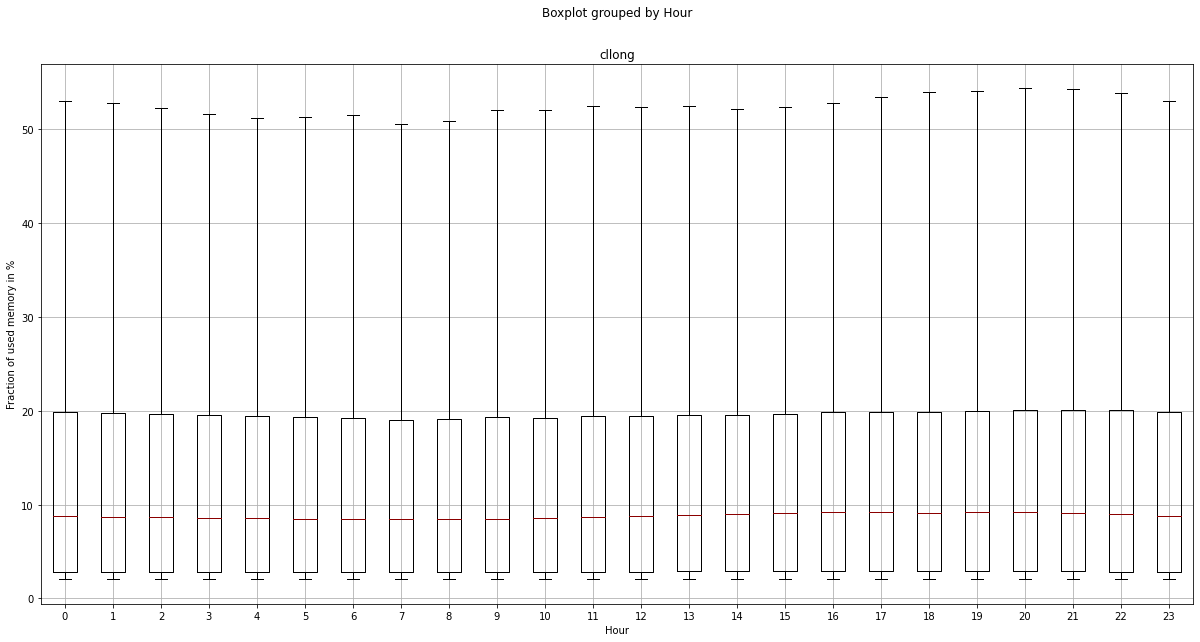

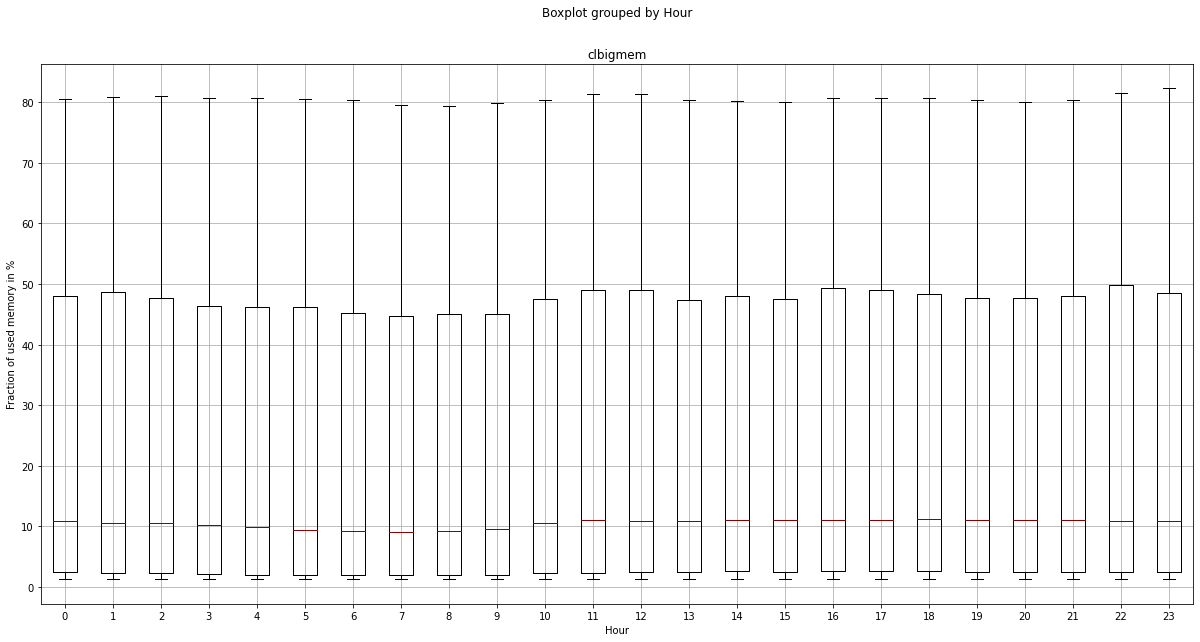

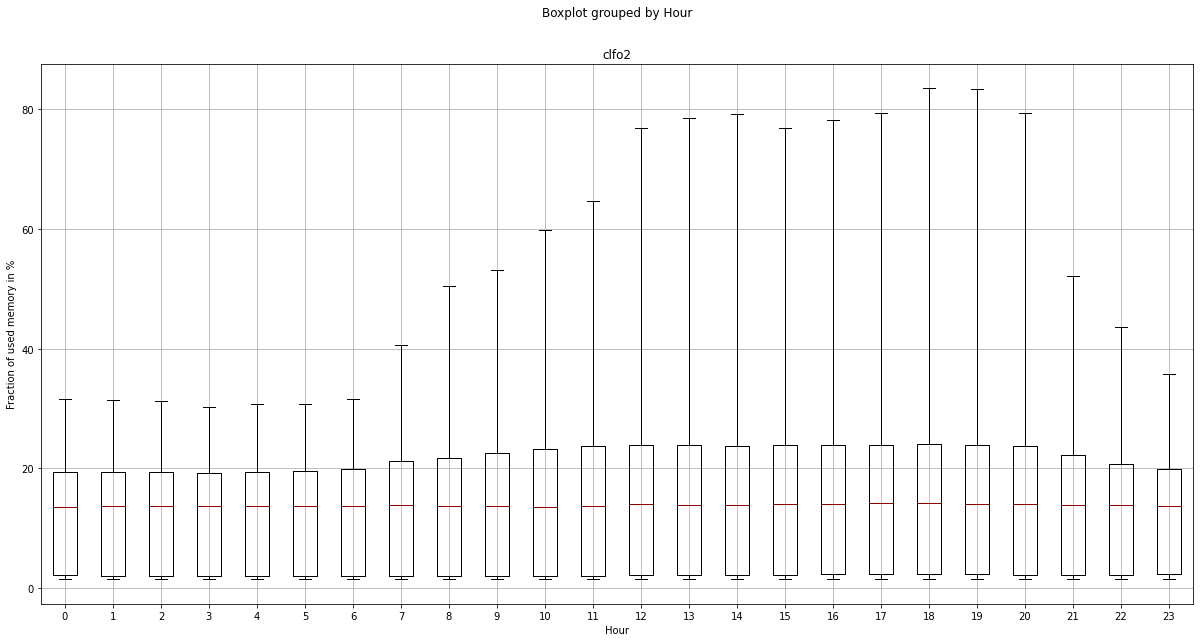

In [21]:
for batch_class in batch_classes:
    Box_plot(host_logs_mem,batch_class)

## Weekly cycle of used memory for all batch classes:

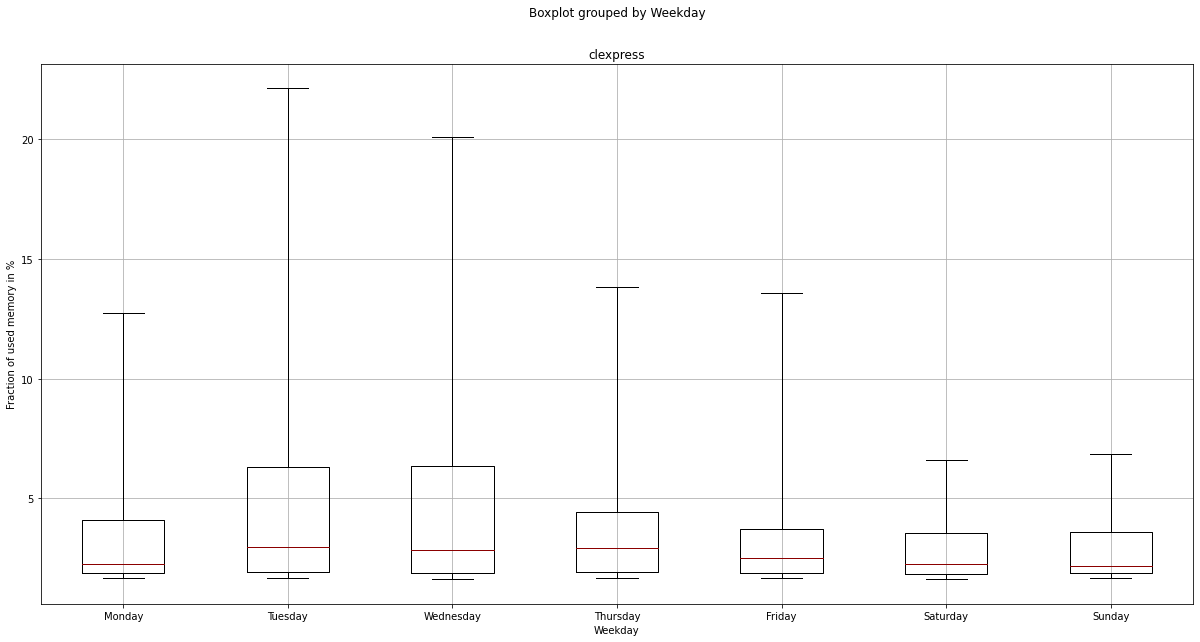

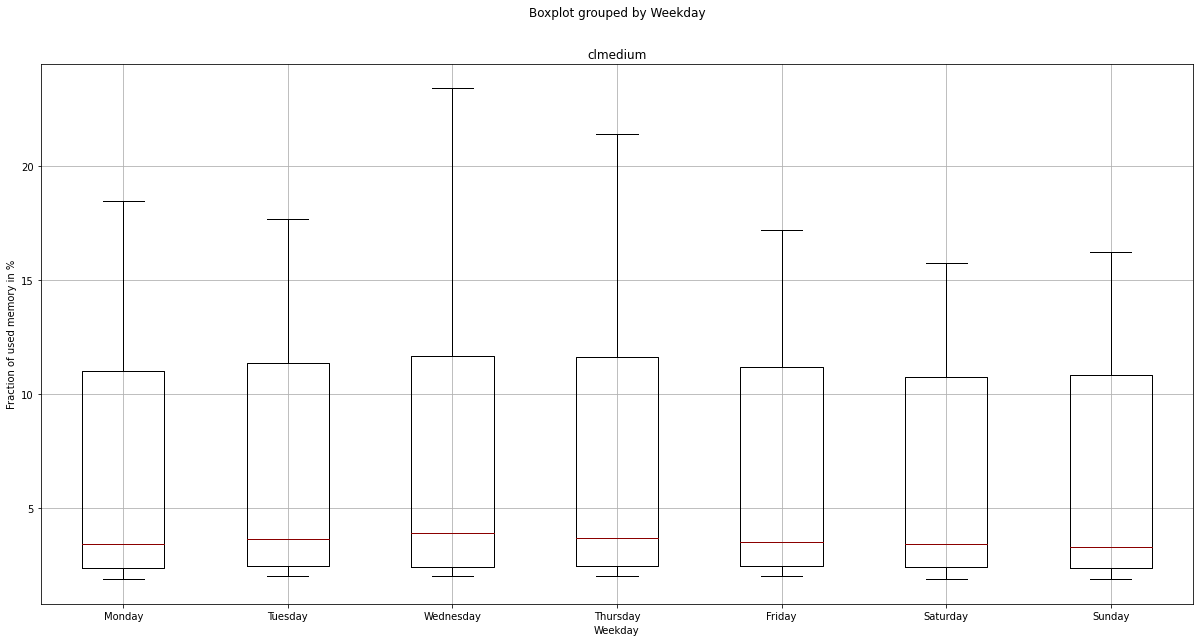

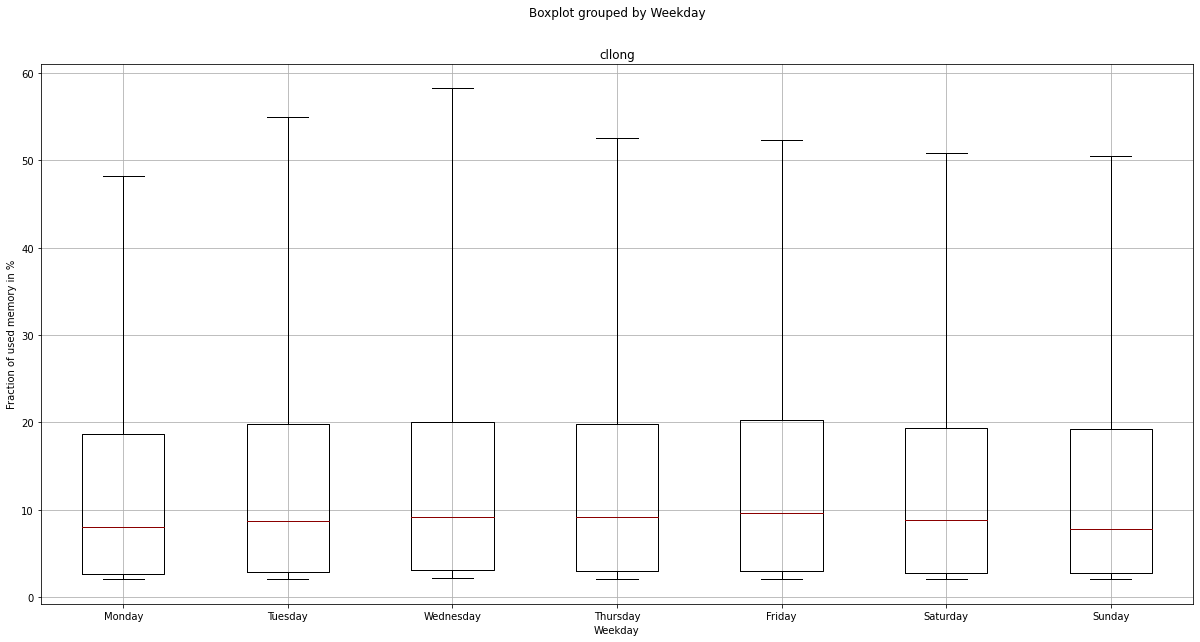

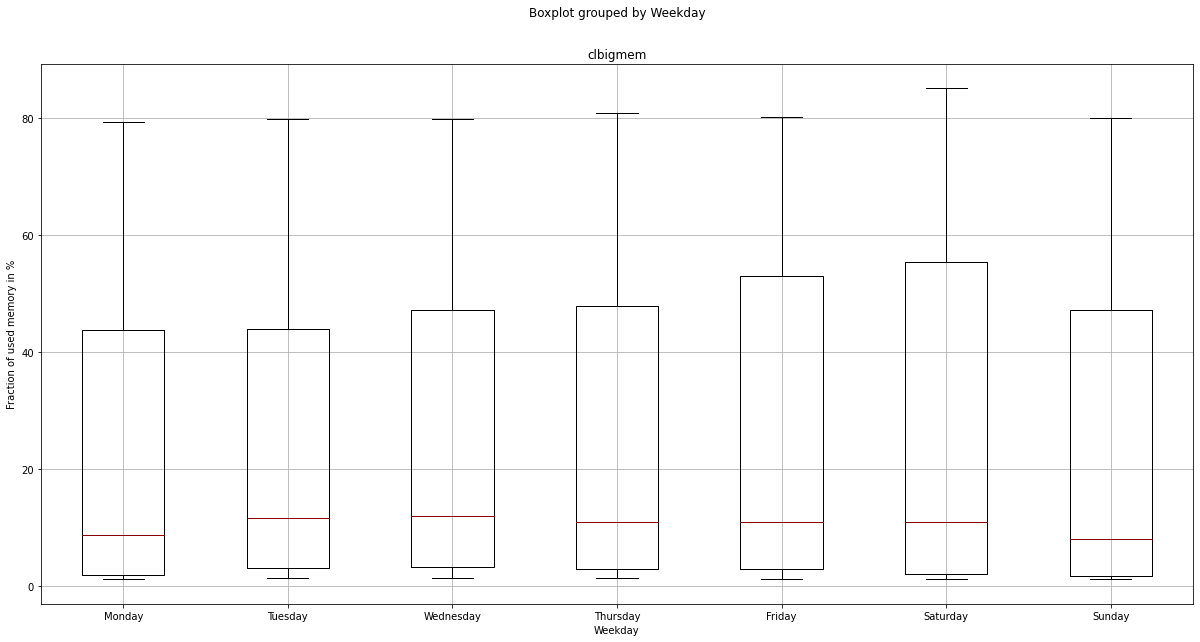

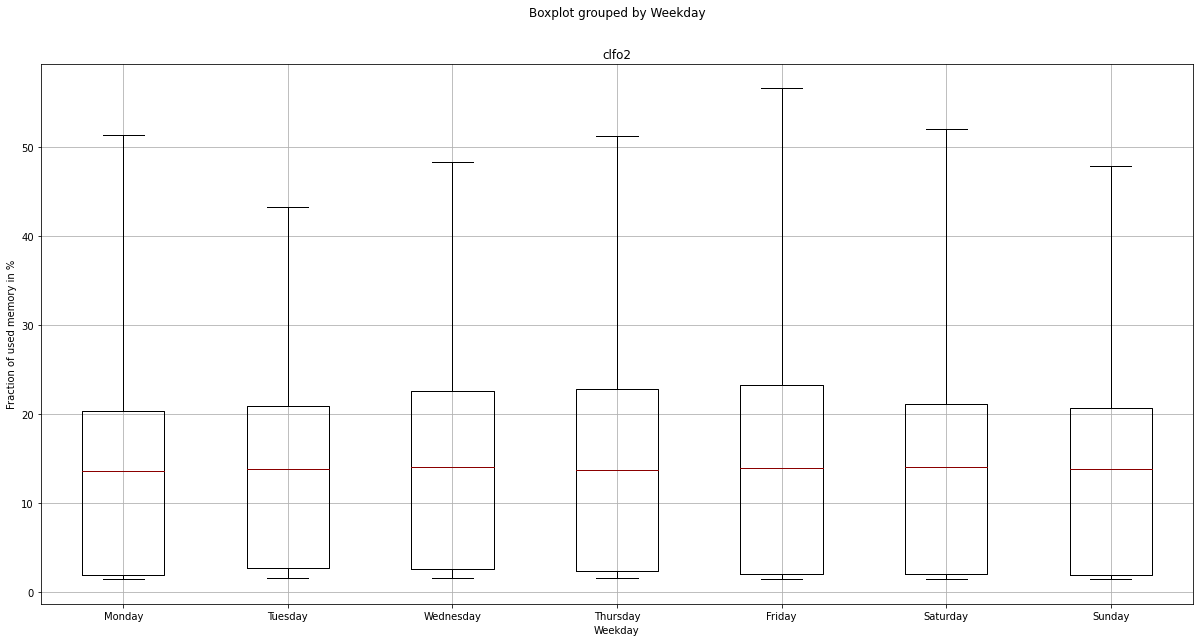

In [22]:
for batch_class in batch_classes:
    Box_plot(host_logs_mem,batch_class,week=True)

## Daily cycle of used CPUs for all batch classes

In [23]:
host_logs_cpu = Resource_Fraction(host_logs, res='CPUs')

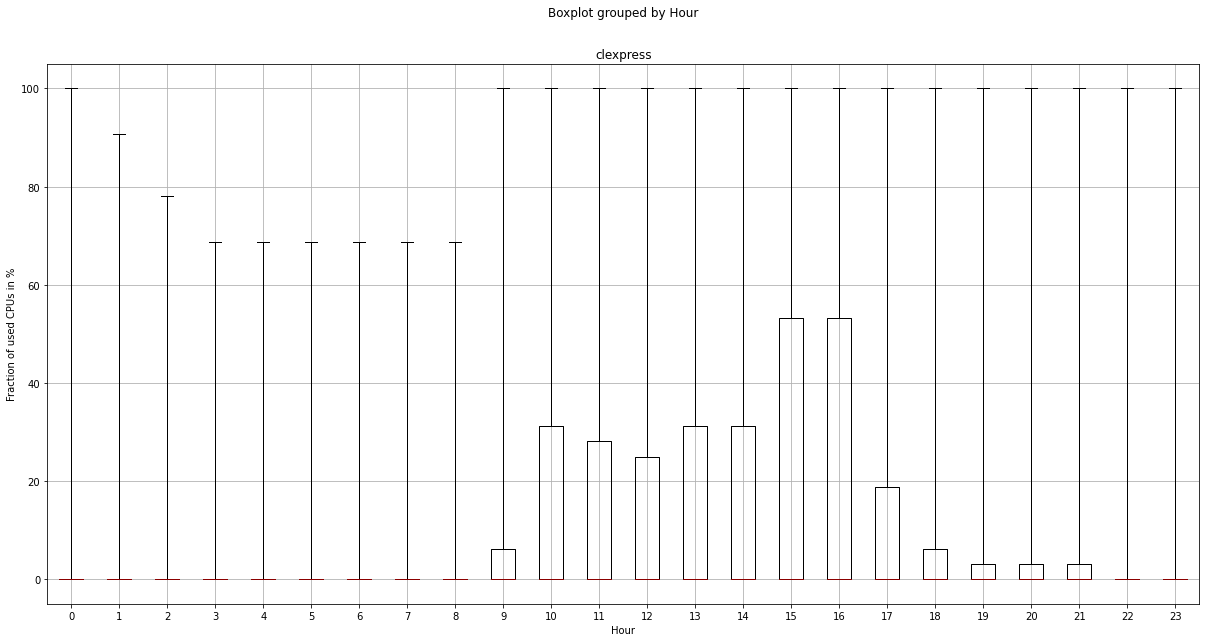

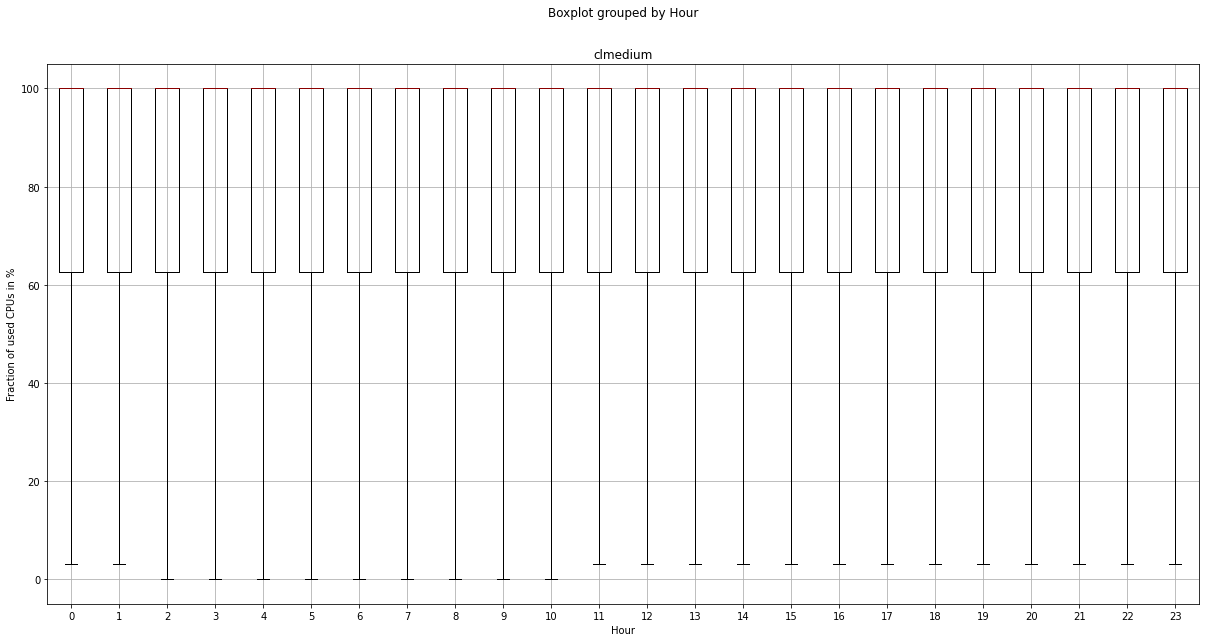

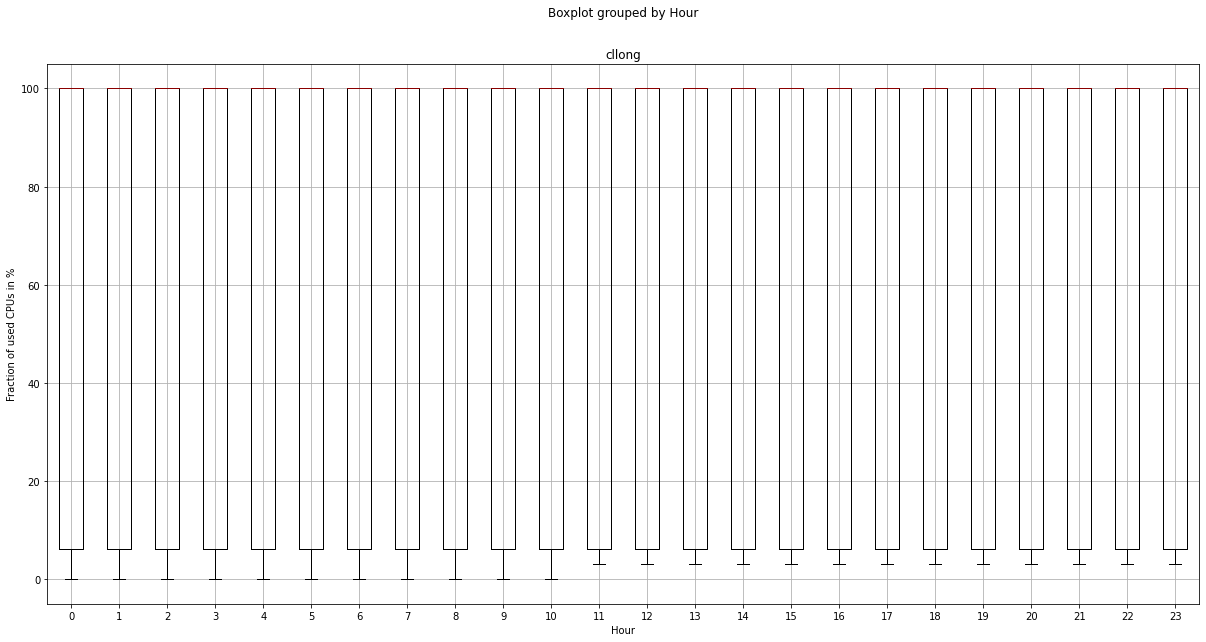

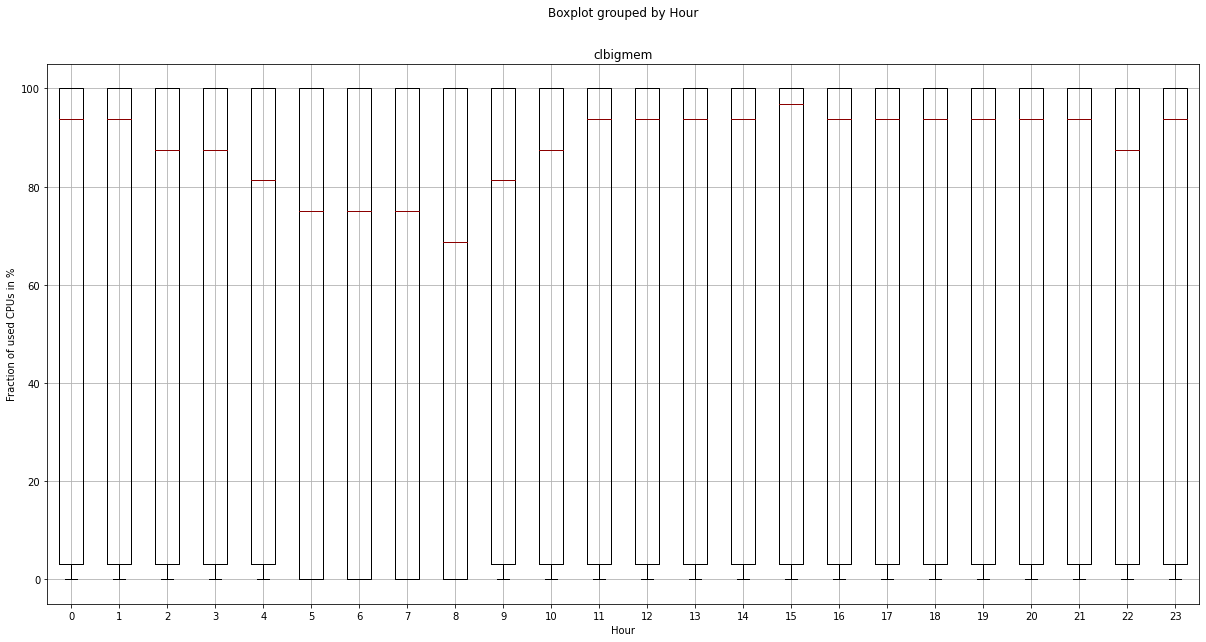

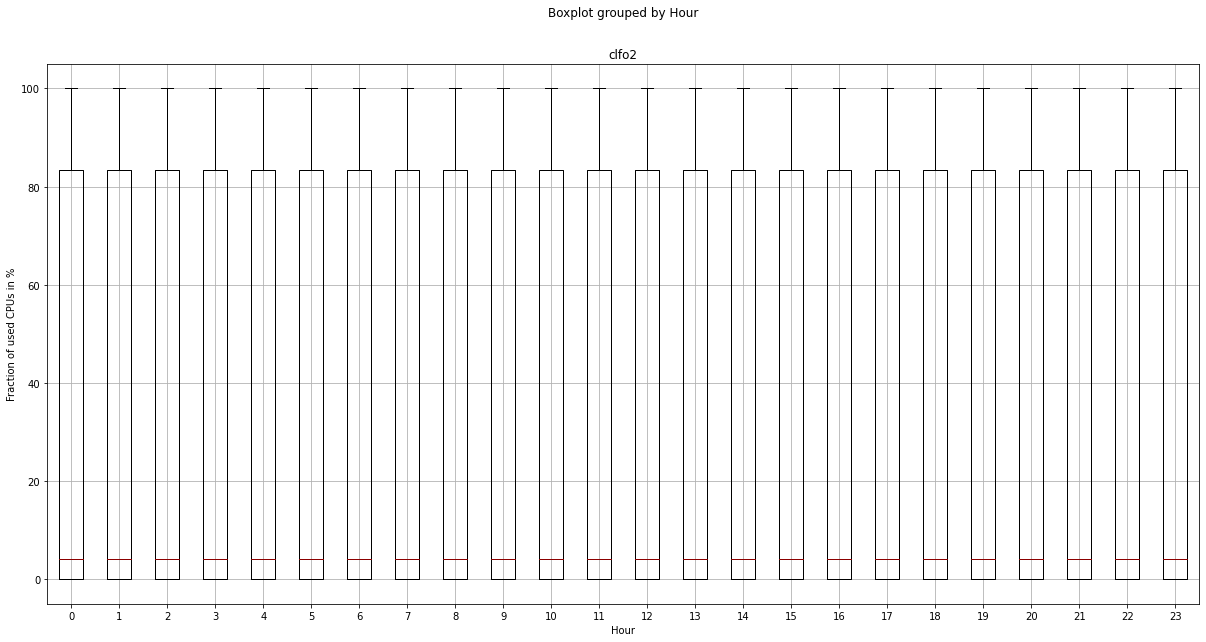

In [35]:
for batch_class in batch_classes:
    Box_plot(host_logs_cpu,batch_class,titlestr='Fraction of used CPUs in %')

## Weekly cycle of used CPUs for all batch classes

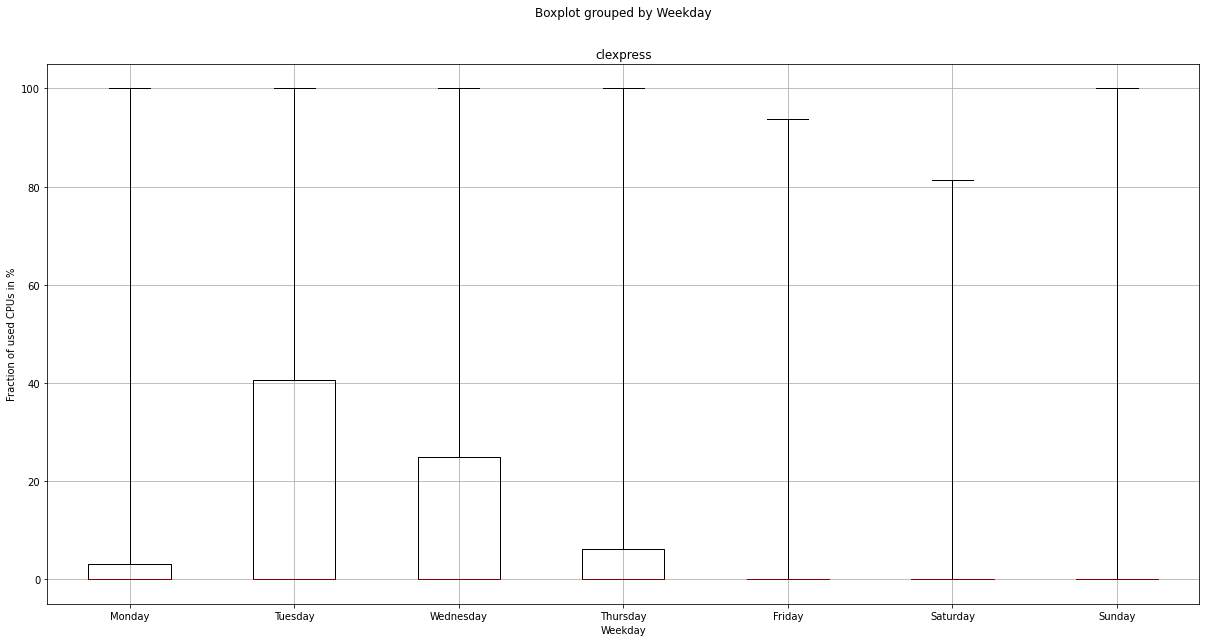

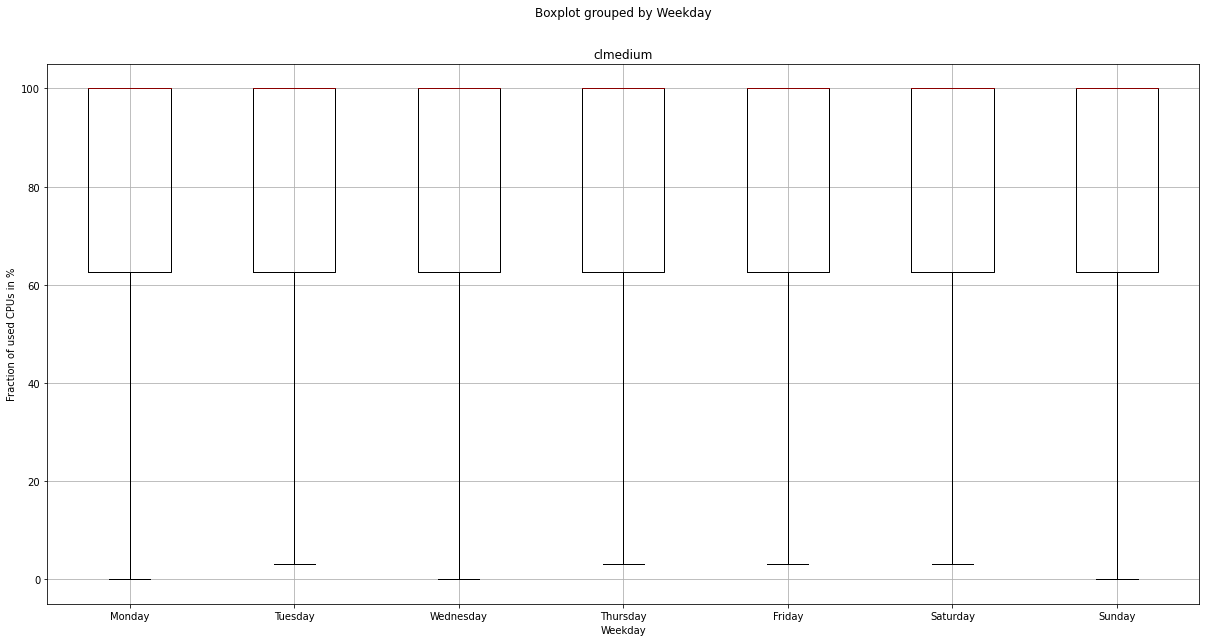

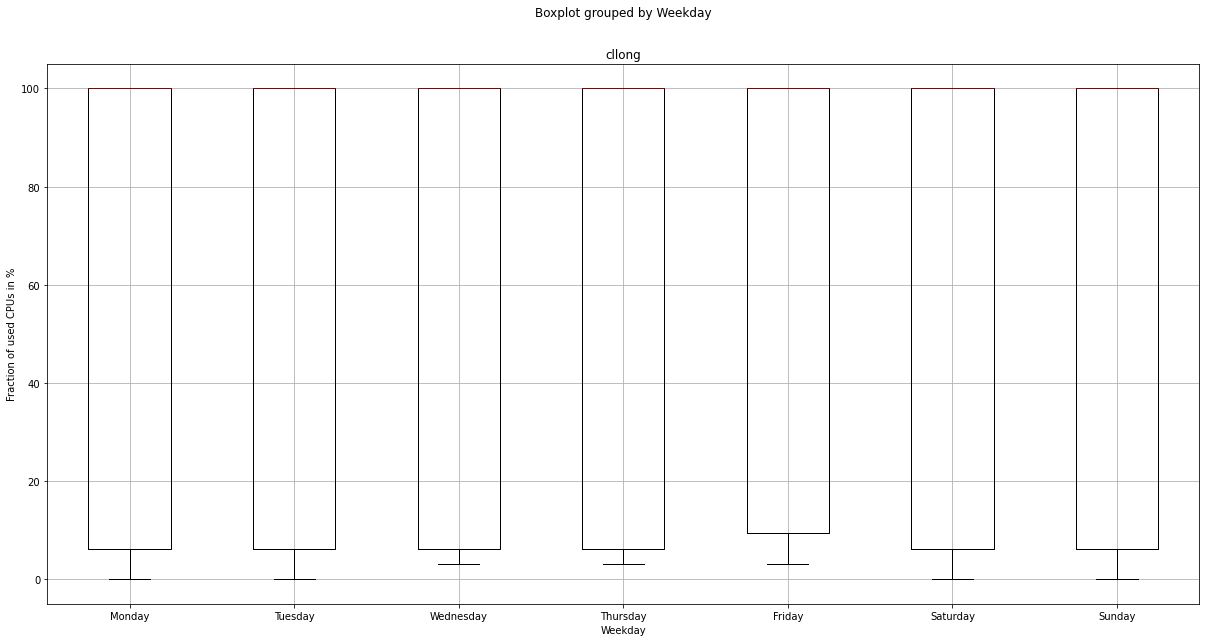

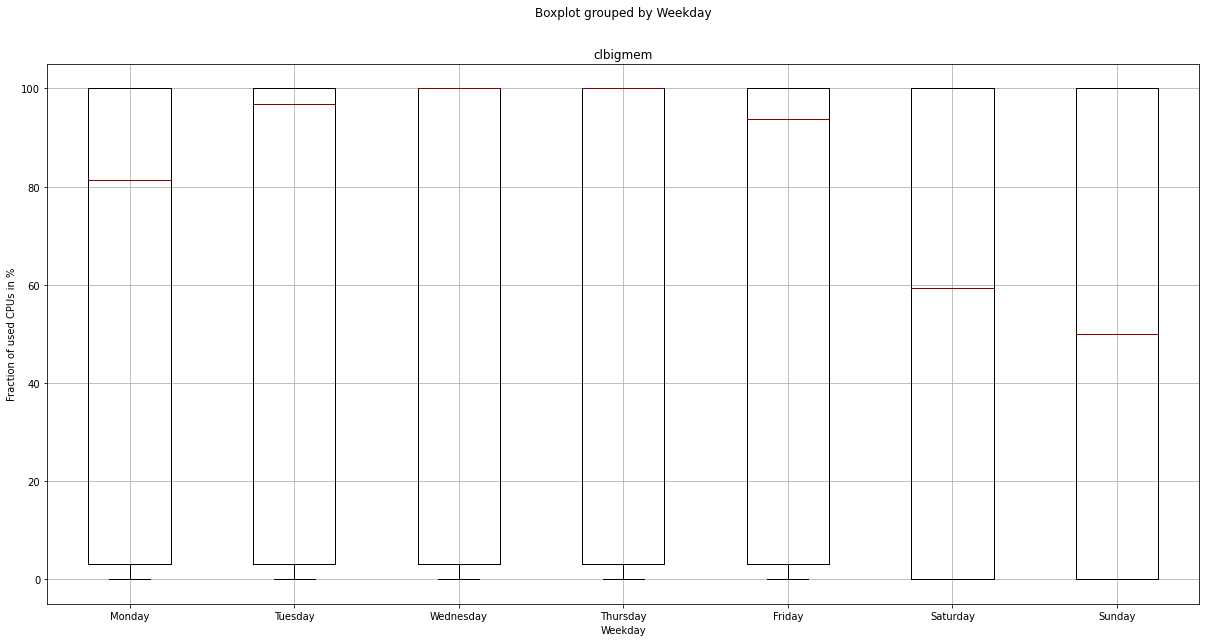

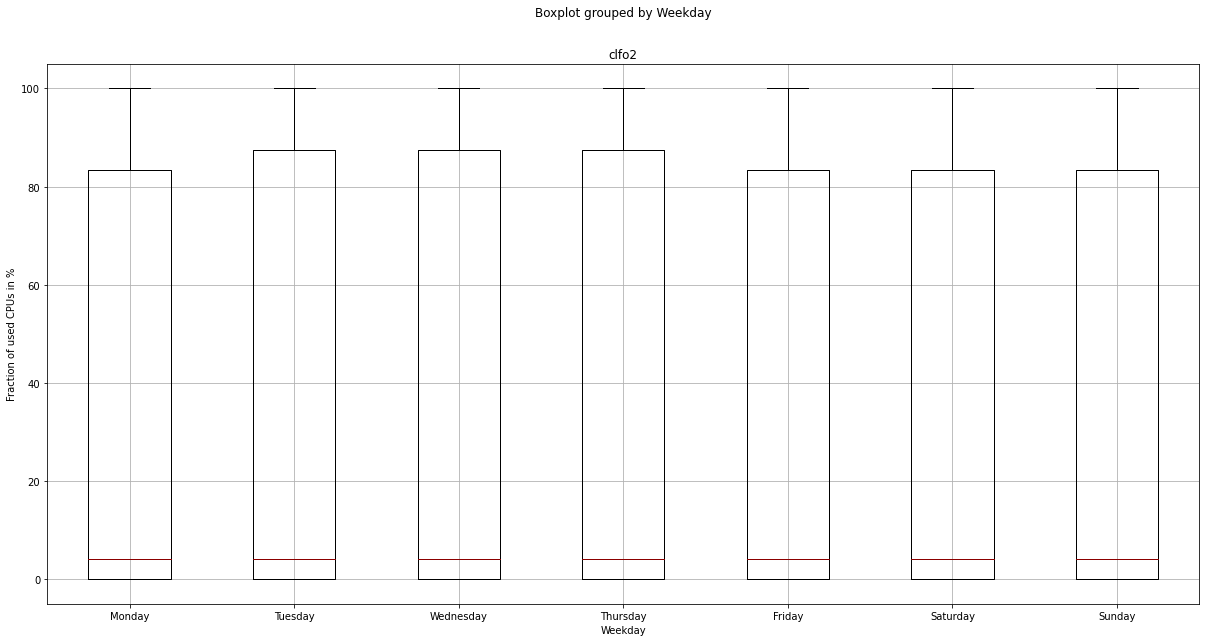

In [36]:
for batch_class in batch_classes:
    Box_plot(host_logs_cpu,batch_class,week=True,titlestr='Fraction of used CPUs in %')

In [26]:
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
0,2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
1,2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6475641,2020-10-07 16:10:08,60,747.976562,4,4.0,18.734375,nesh-fe1-adm,nan,2.585938,1.410156,4.0
6475642,2020-10-07 16:10:08,60,746.683594,4,4.3,20.027344,nesh-fe2-adm,nan,0.000000,3.996094,4.8


In [27]:
cluster_utilization = host_logs[['Date','Free_CPUs','Free_Mem1','Used_CPUs','Used_Mem1','Cpu','QueueName']].groupby(['Date','QueueName']).sum().reset_index()

In [28]:
cluster_utilization

,Date,QueueName,Free_CPUs,Free_Mem1,Used_CPUs,Used_Mem1,Cpu
0,2020-01-12 18:17:31,clbigmem,61,2785.464844,195,276.222656,194.4
1,2020-01-12 18:17:31,clexpress,64,371.171875,0,10.250000,0.0
...,...,...,...,...,...,...,...
261582,2020-10-07 16:10:08,feque,64,195.578125,0,571.132812,0.0
261583,2020-10-07 16:10:08,nan,120,1494.660156,8,38.761719,8.3


In [29]:
mem_utilization = Resource_Fraction(cluster_utilization)
cpu_utilization = Resource_Fraction(cluster_utilization, res='CPUs')

## Daily cycles of used memory for all batch classes:

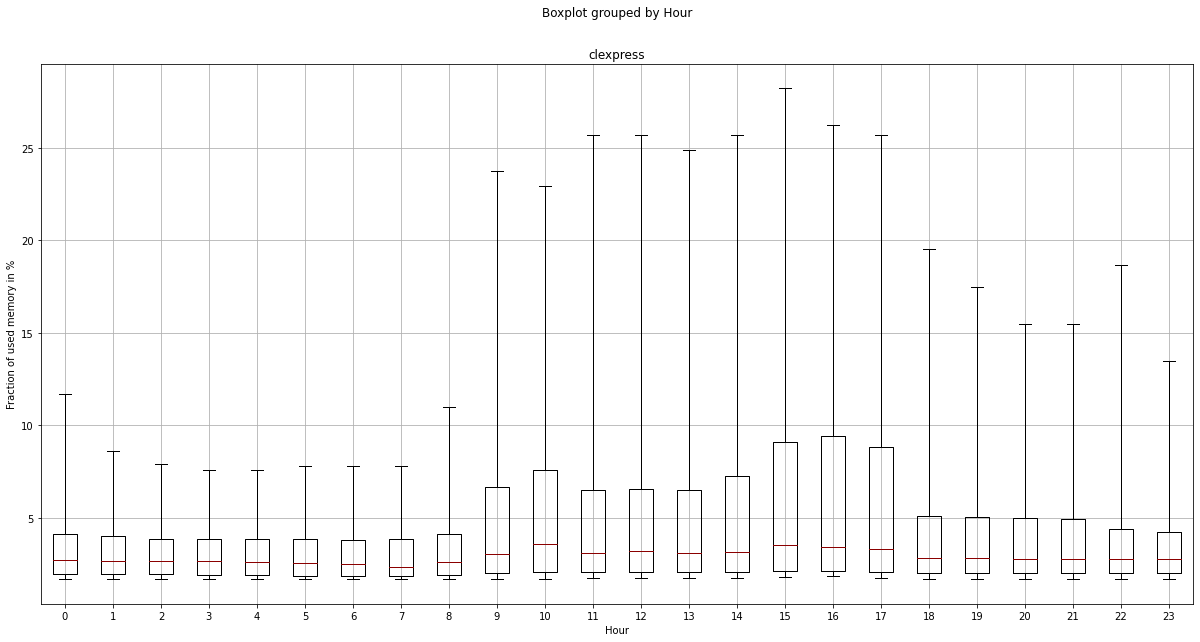

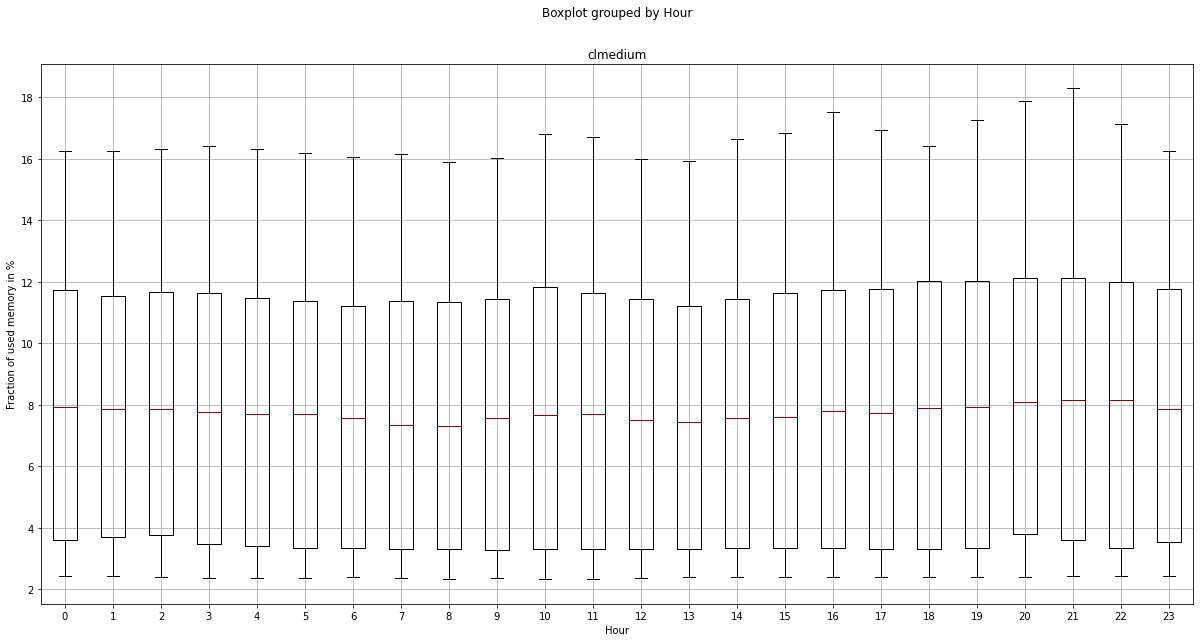

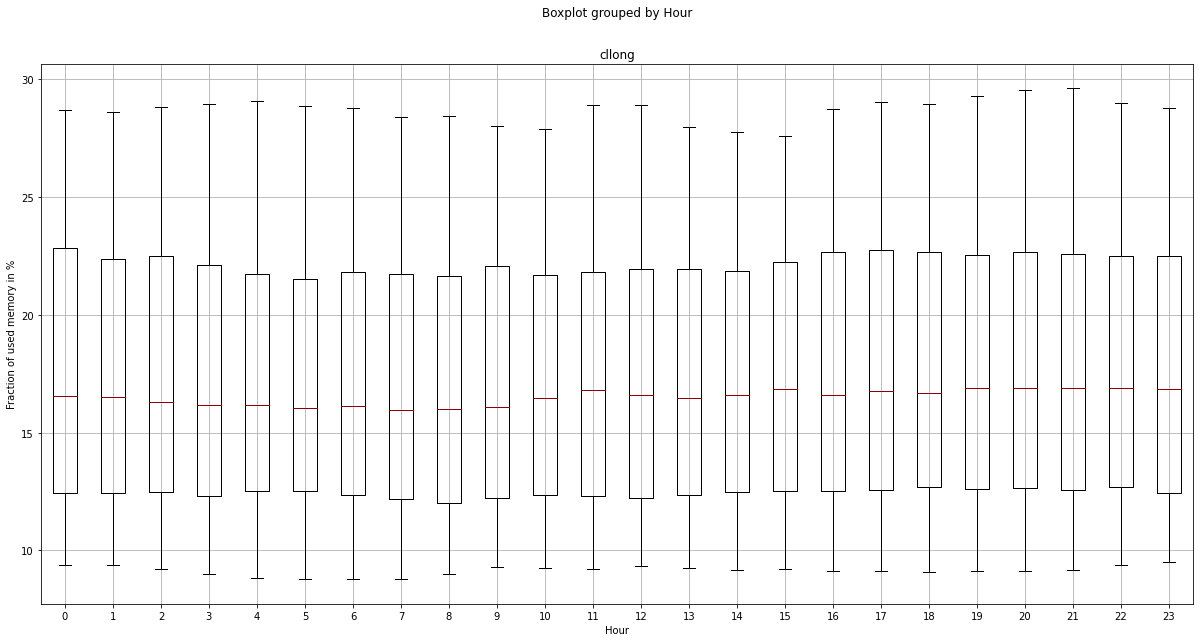

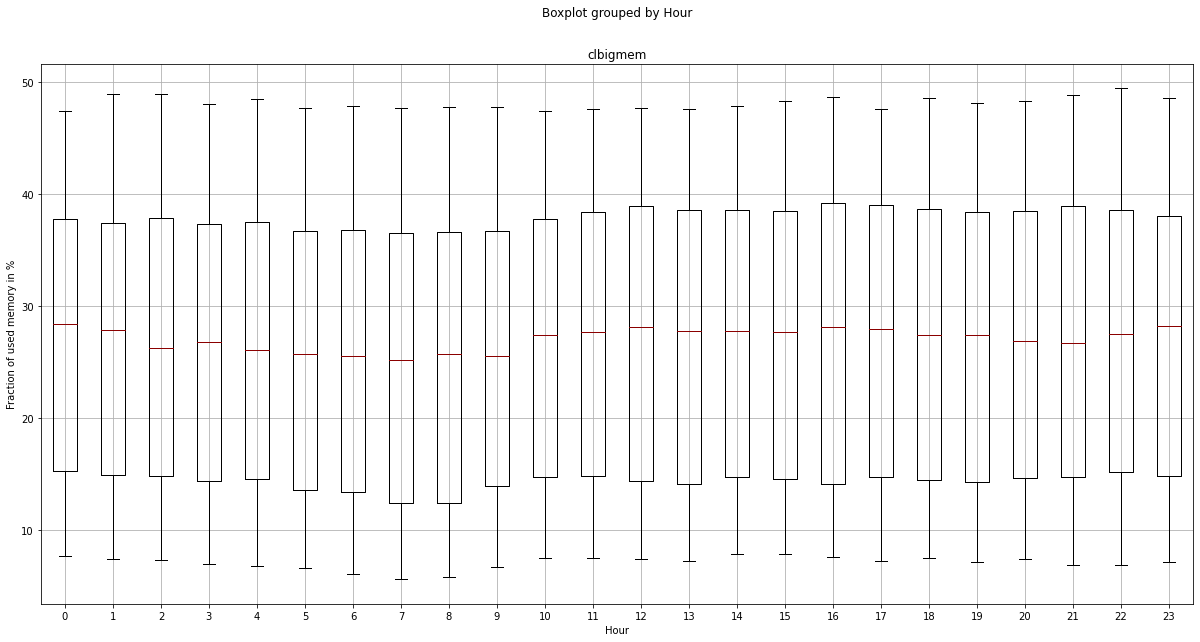

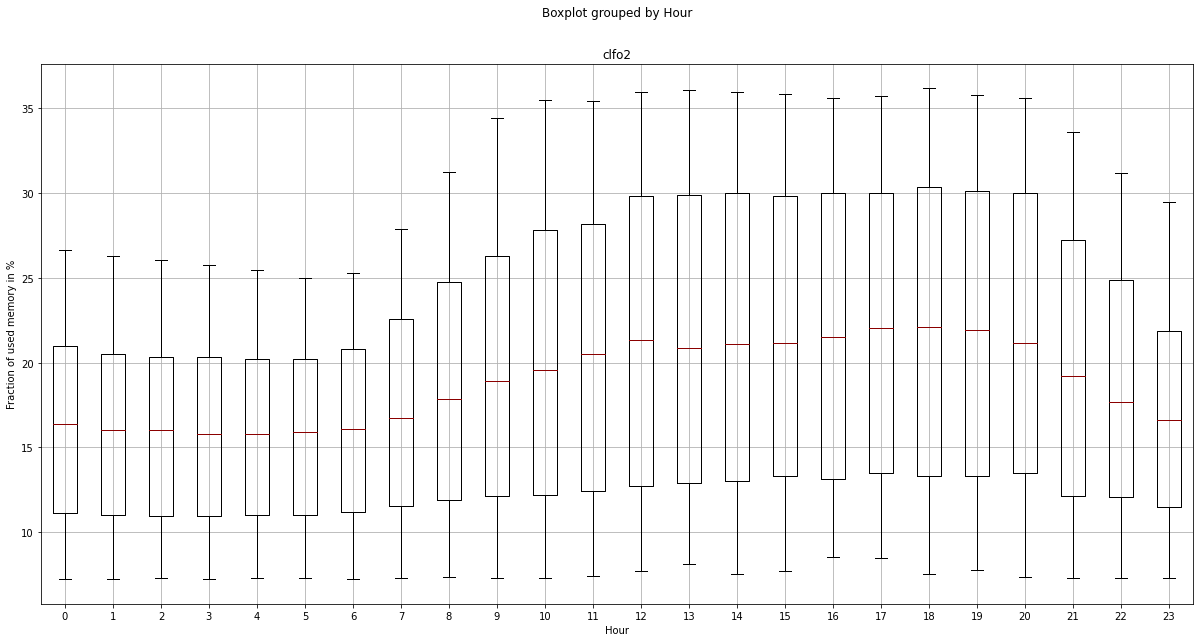

In [30]:
for batch_class in batch_classes:
    Box_plot(mem_utilization,batch_class)

## Weekly cycle of used memory for all batch classes :

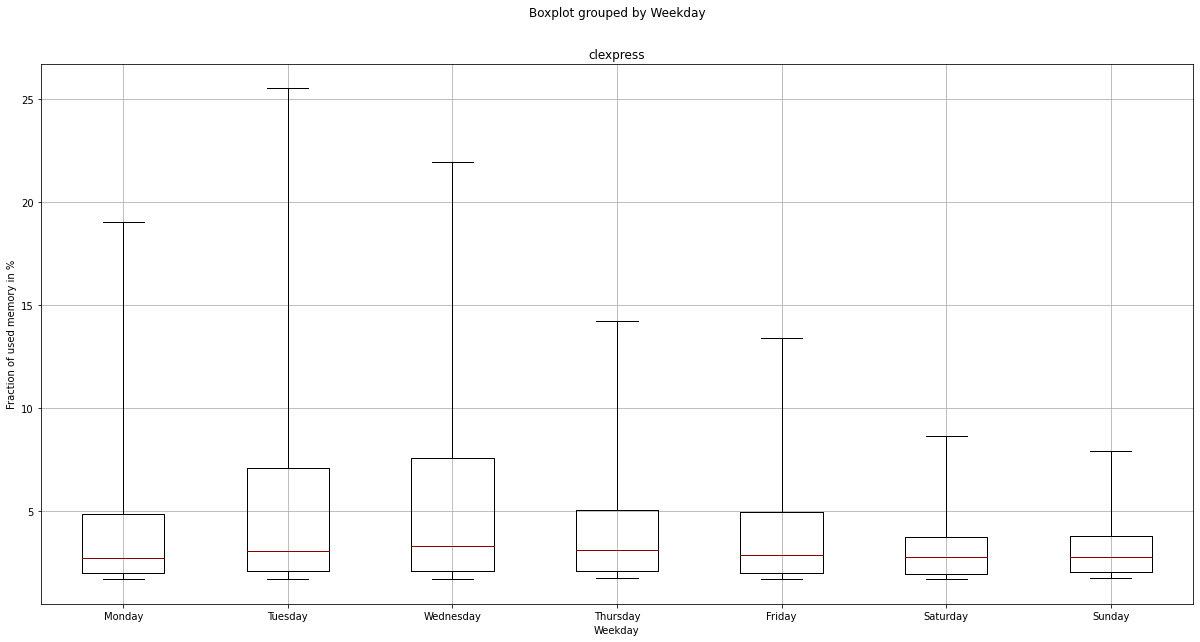

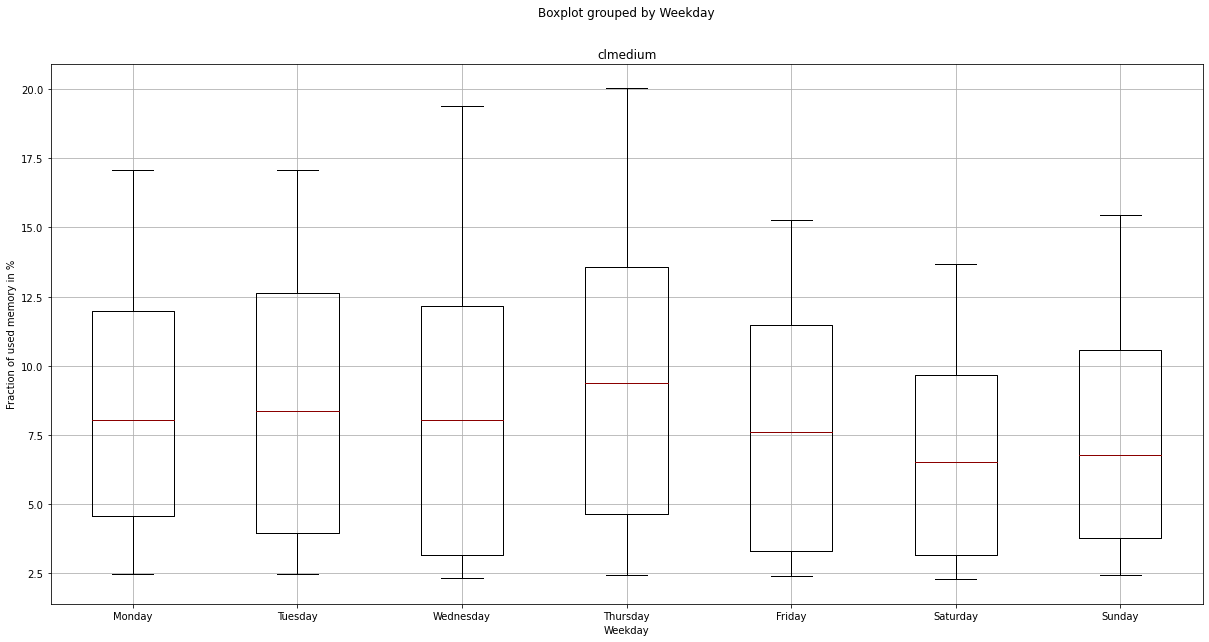

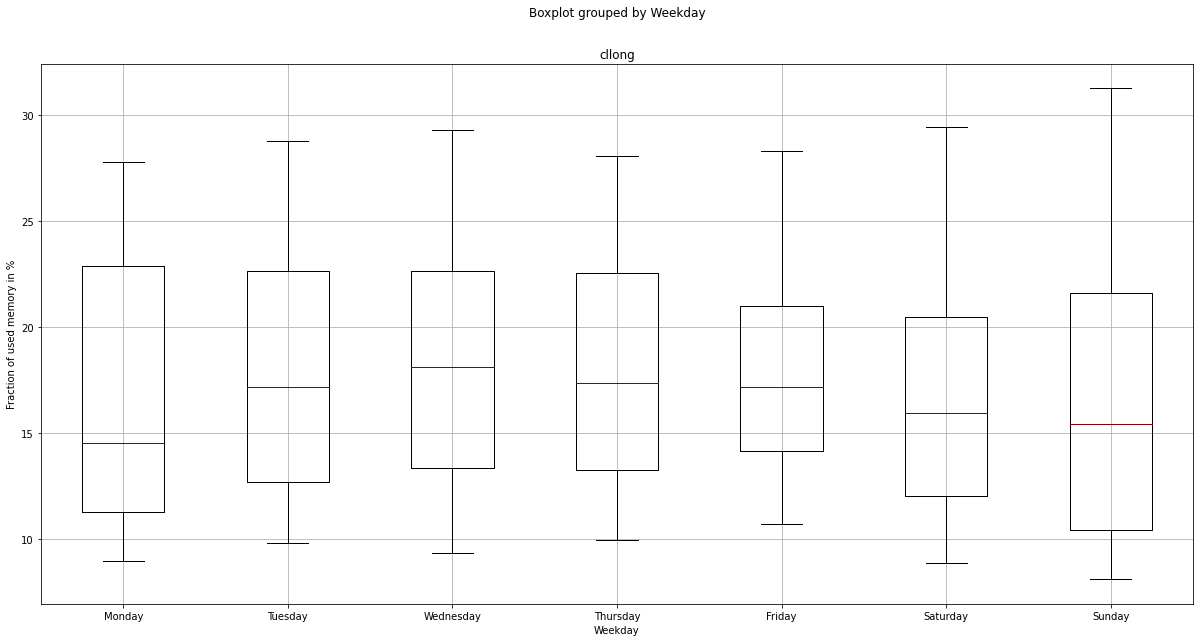

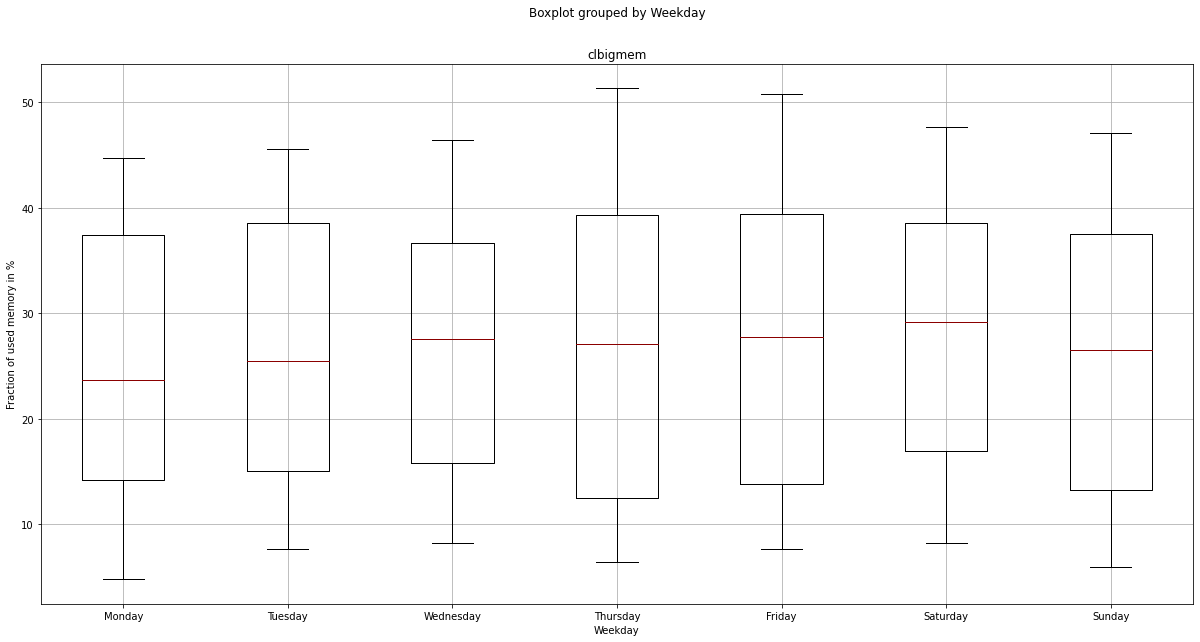

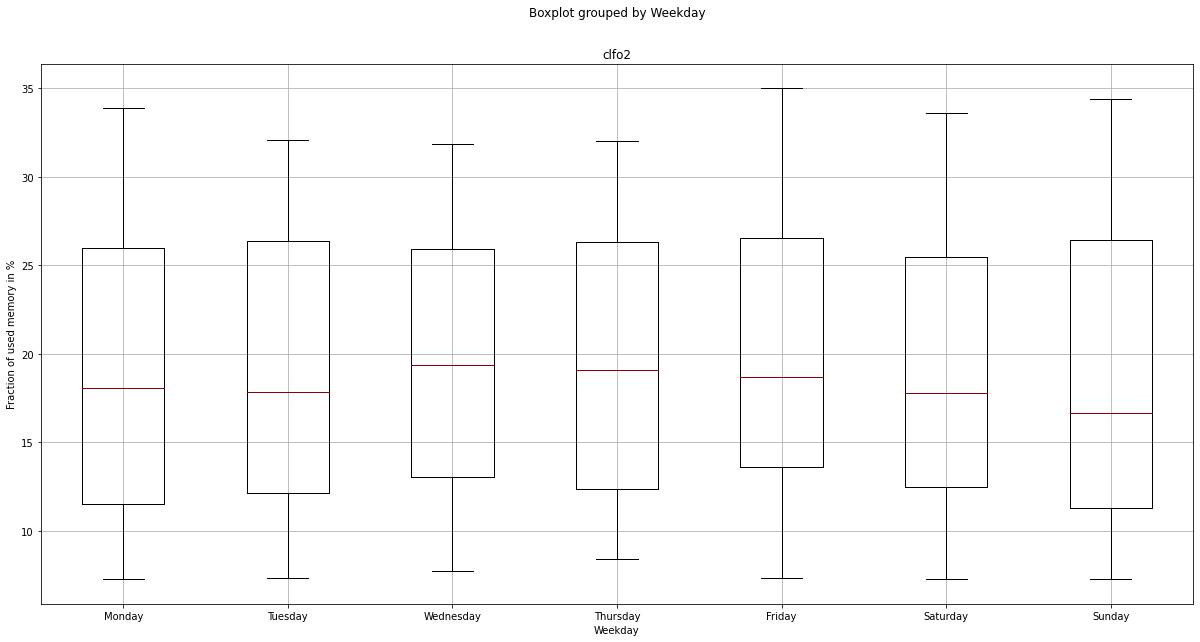

In [31]:
for batch_class in batch_classes:
    Box_plot(mem_utilization,batch_class,week=True)

## Daily cycle of used CPUs for all batch classes

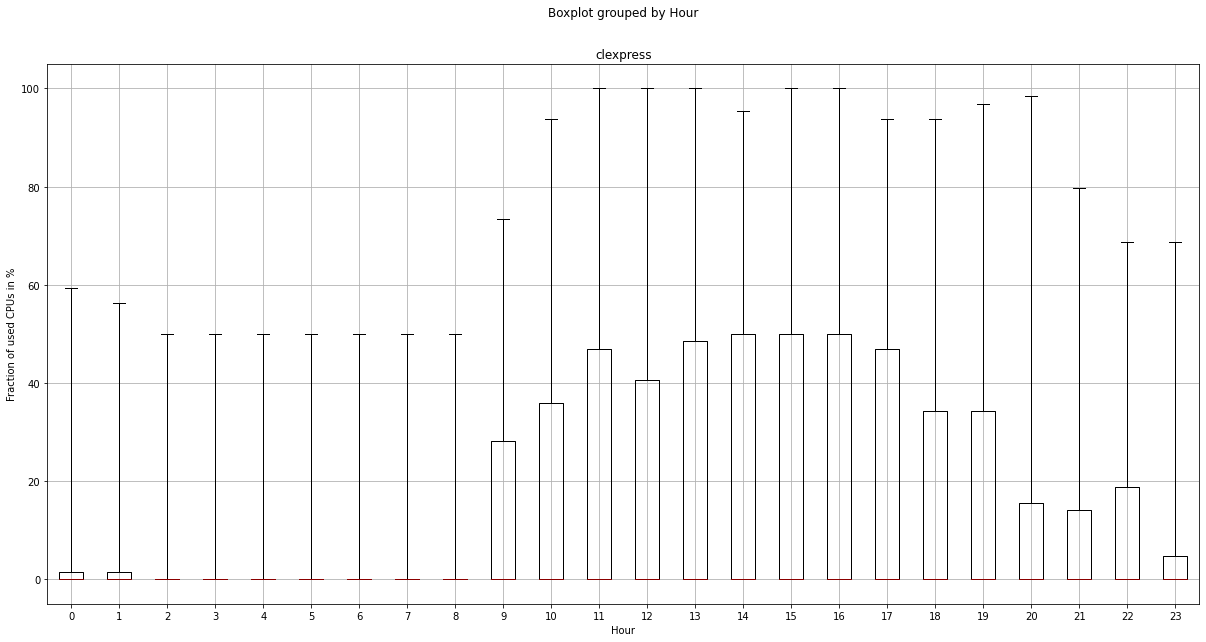

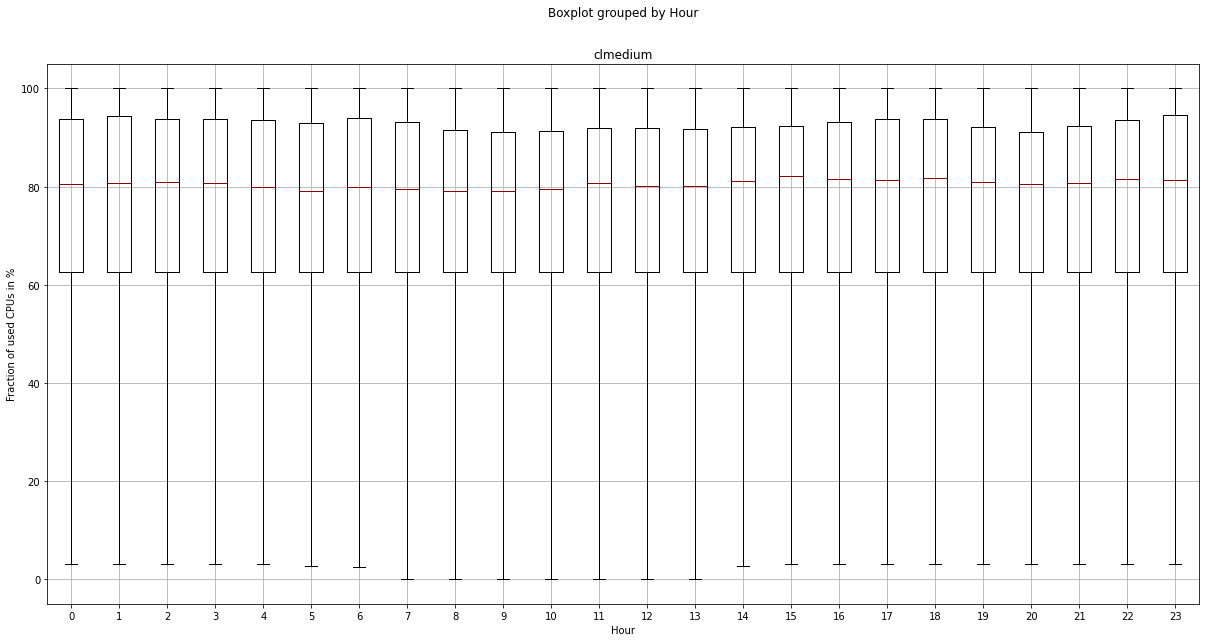

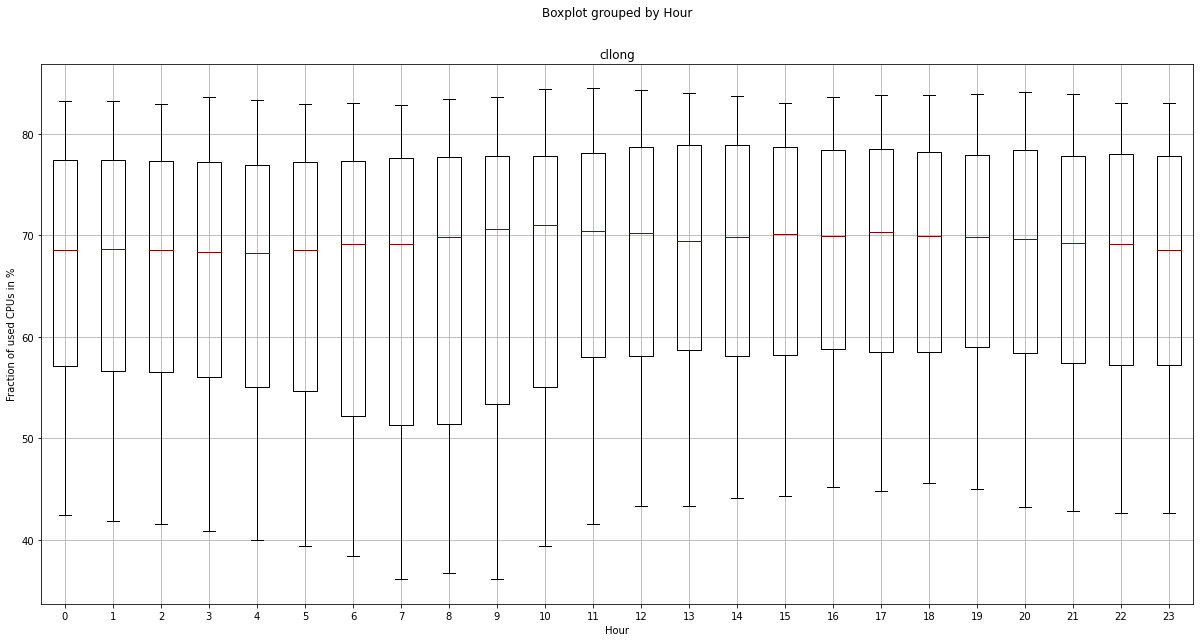

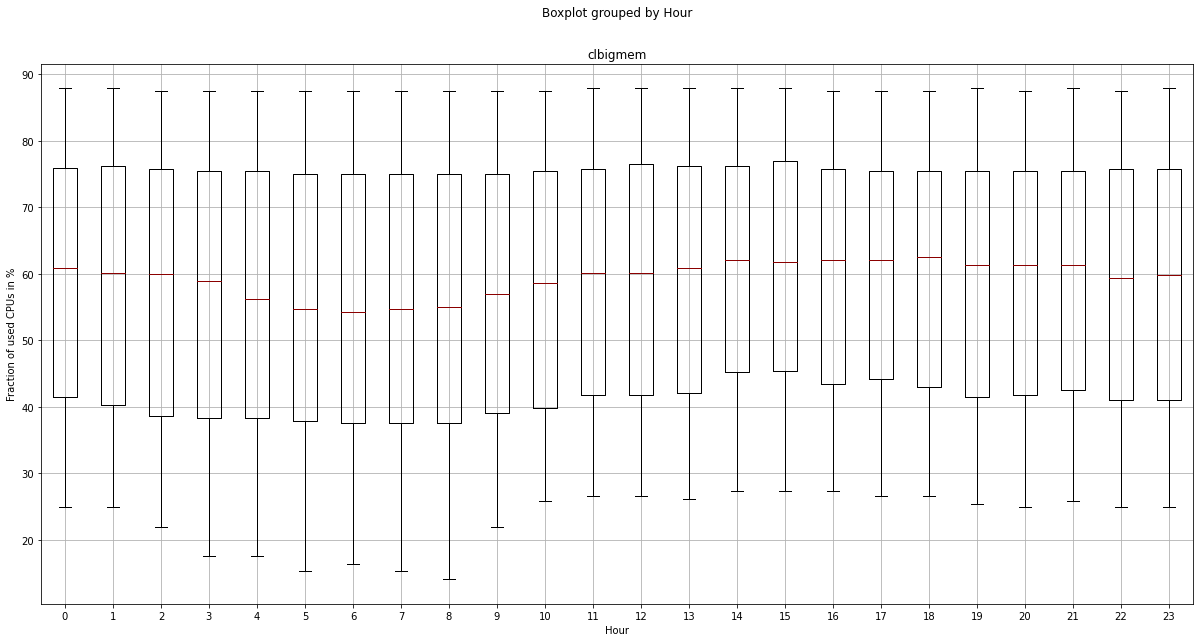

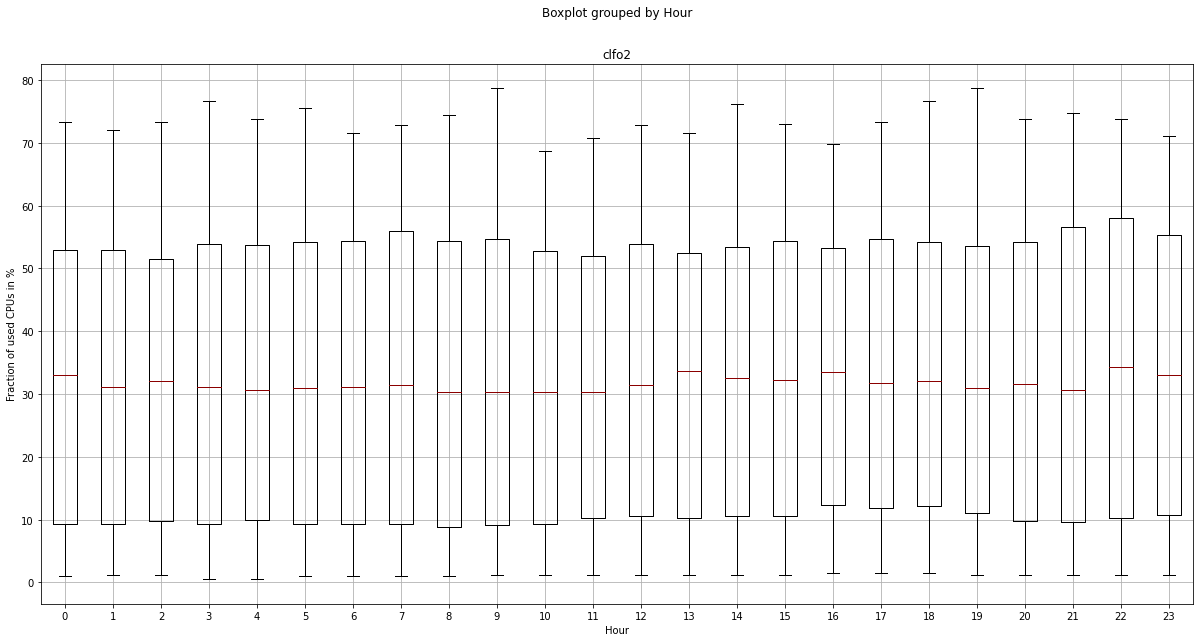

In [32]:
for batch_class in batch_classes:
    Box_plot(cpu_utilization,batch_class,titlestr='Fraction of used CPUs in %')

## Weekly cycle of used CPUs for all batch classes

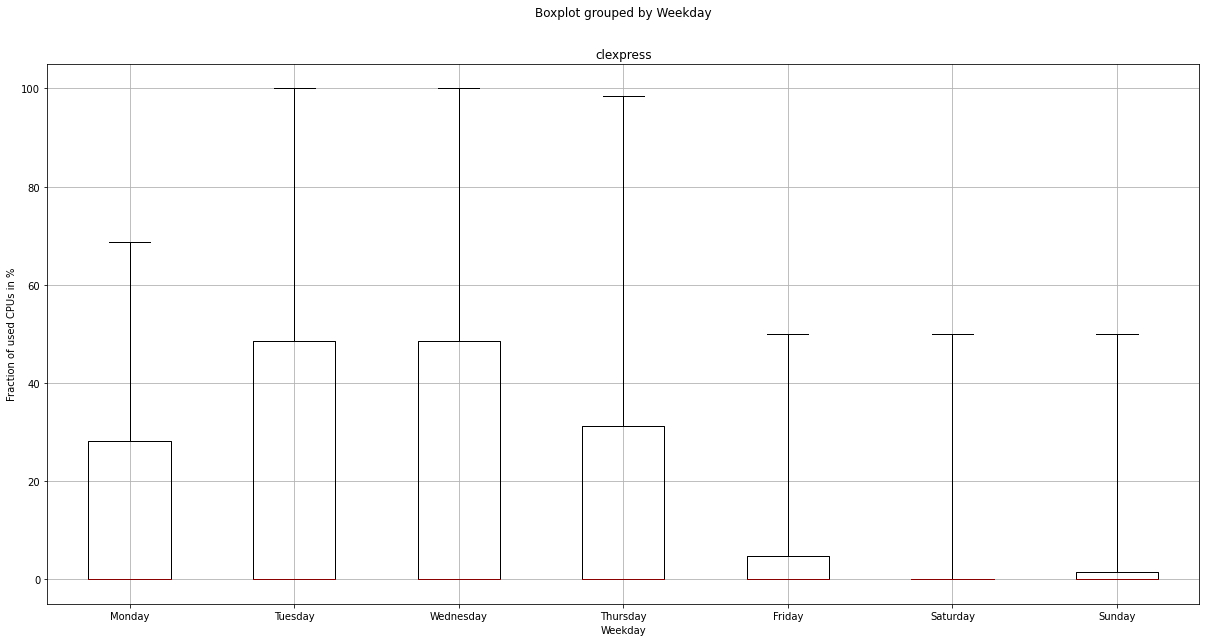

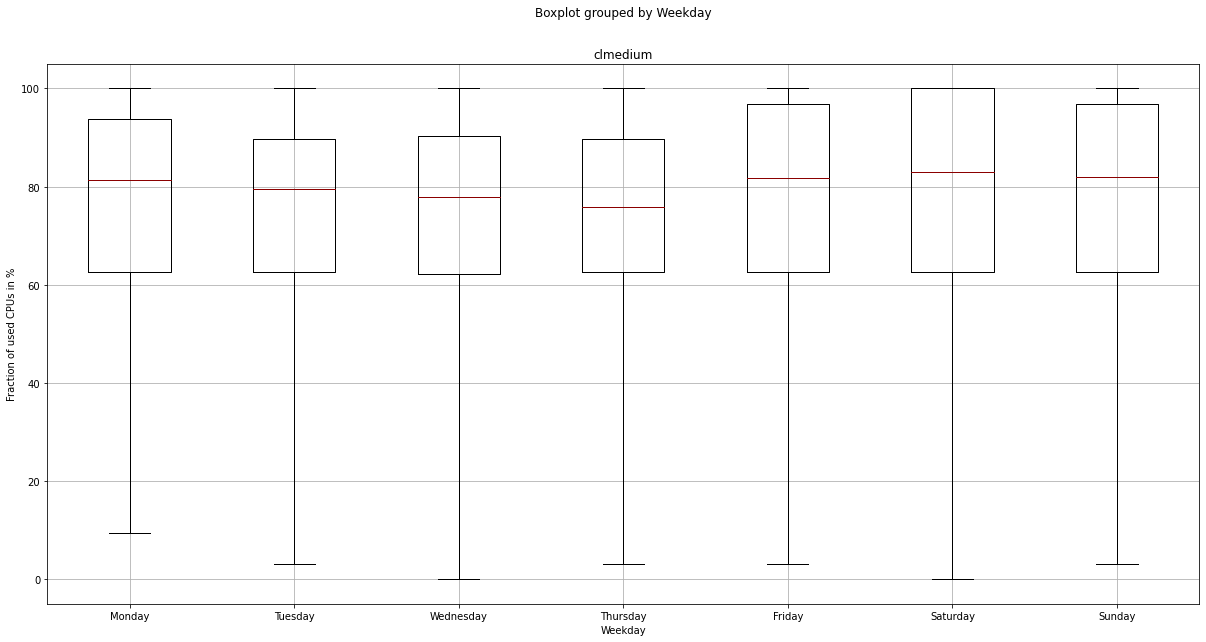

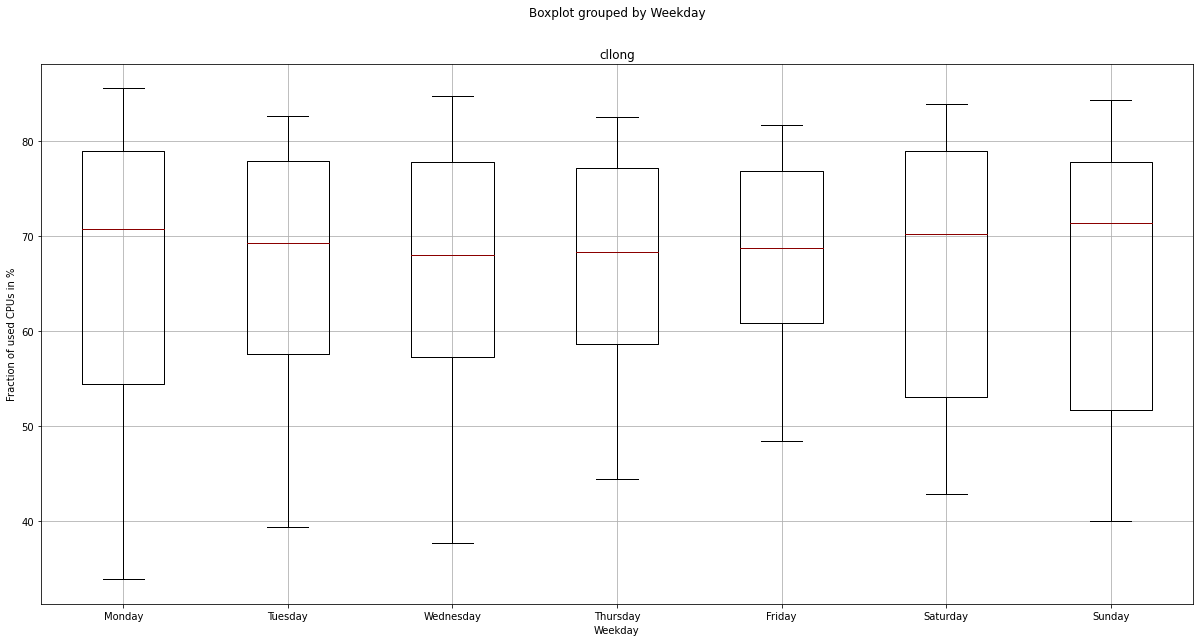

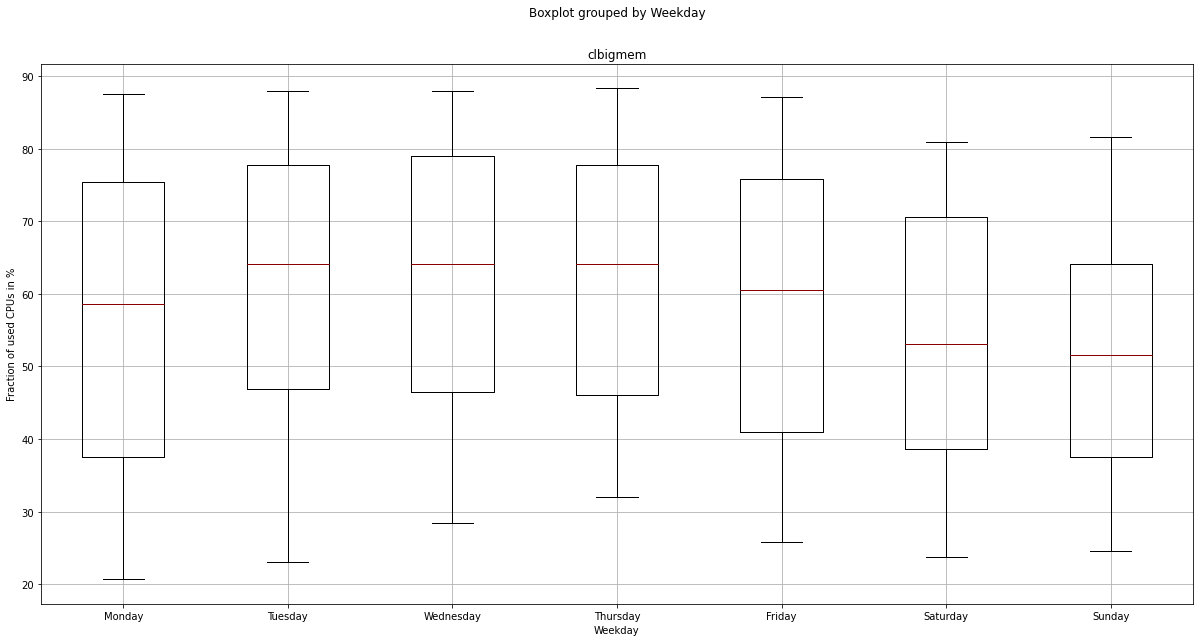

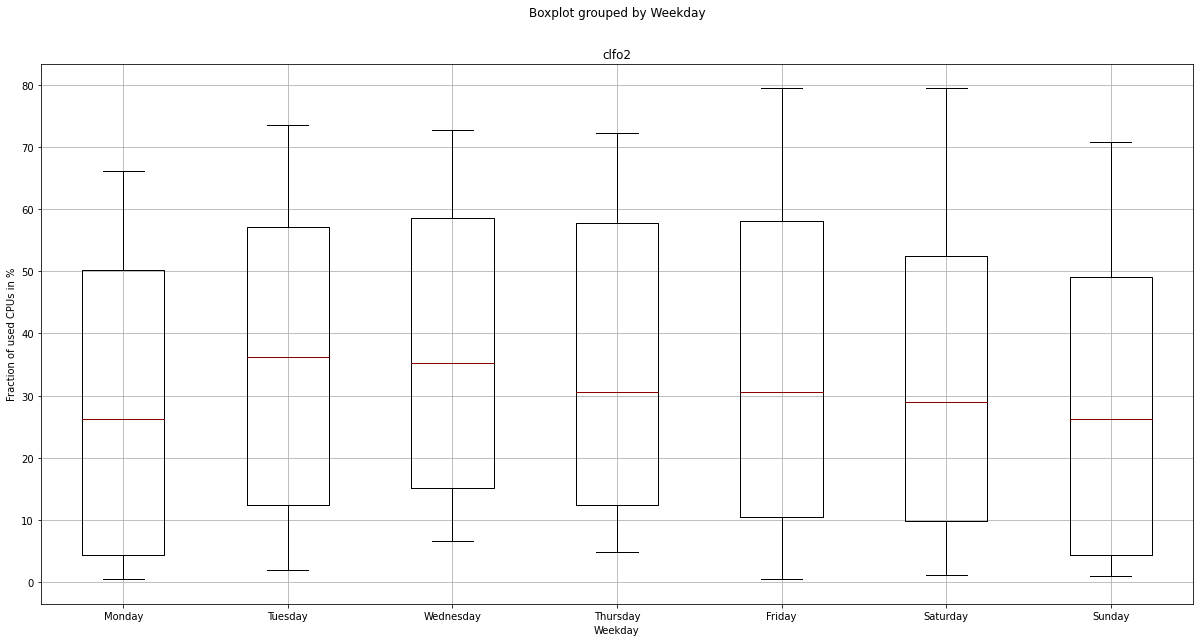

In [34]:
for batch_class in batch_classes:
    Box_plot(cpu_utilization,batch_class,week=True,titlestr='Fraction of used CPUs in %')

# Python environment

In [22]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/git-lfs-2.11.0-0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/nomkl-1.0-h5ca1d4c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.6.20-hecda079_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.35-h769bd43_9.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran5-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.3.0-h2ae2ef3_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/pandoc-2.11.0.4-hd18ef5c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgomp-9.3.0-h5dbcf3e_17.tar.bz2
https://conda.anacon